In [5]:
"""
ACP Journal Complete Data Harvester
====================================
完整采集ACP期刊2020-2024年文章元数据，包含Abstract

功能：
1. OAI-PMH批量采集（含Abstract）
2. HTML清理与文本预处理
3. 关键词自动提取（从Abstract）
4. Crossref引用数补充（可选）
5. 断点续传支持
6. 多格式输出

运行环境：Jupyter Notebook / Python 3.8+
依赖包：requests, pandas, lxml, tqdm, beautifulsoup4

作者：Claude Assistant
日期：2024年12月
"""

# =============================================================================
# Cell 1: 安装依赖
# =============================================================================
# !pip install requests pandas lxml tqdm beautifulsoup4 openpyxl

# =============================================================================
# Cell 2: 导入库
# =============================================================================
import requests
import pandas as pd
from lxml import etree
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import os
import json
import re
from tqdm import tqdm
import hashlib

print("库导入完成！")

# =============================================================================
# Cell 3: 配置参数
# =============================================================================

# OAI-PMH基础配置
OAI_BASE_URL = "https://oai-pmh.copernicus.org/oai.php"
METADATA_PREFIX = "oai_dc"  # Dublin Core格式（已验证有Abstract）
SET_SPEC = "acp"            # ACP期刊集合

# 时间范围
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# ============================================================================
# 输出配置 - 使用用户指定的路径
# ============================================================================
BASE_OUTPUT_DIR = "/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract"

# 子目录结构
OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "data")          # 数据文件
CHECKPOINT_DIR = os.path.join(BASE_OUTPUT_DIR, "checkpoint") # 断点文件
LOG_DIR = os.path.join(BASE_OUTPUT_DIR, "logs")             # 日志文件

OUTPUT_PREFIX = "acp_articles_with_abstract"

# 请求配置
REQUEST_DELAY = 1.0  # 请求间隔（秒）
MAX_RETRIES = 3      # 最大重试次数
TIMEOUT = 60         # 请求超时（秒）

# 功能开关
FETCH_CITATIONS = False  # 是否从Crossref获取引用数（较慢）
EXTRACT_KEYWORDS = True  # 是否从Abstract自动提取关键词

# 创建所有输出目录
for dir_path in [OUTPUT_DIR, CHECKPOINT_DIR, LOG_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print("配置完成！")
print(f"  - 时间范围: {START_DATE} 至 {END_DATE}")
print(f"  - 基础输出目录: {BASE_OUTPUT_DIR}")
print(f"  - 数据目录: {OUTPUT_DIR}")
print(f"  - 断点目录: {CHECKPOINT_DIR}")
print(f"  - 日志目录: {LOG_DIR}")
print(f"  - 获取引用数: {'是' if FETCH_CITATIONS else '否'}")

# =============================================================================
# Cell 4: XML命名空间
# =============================================================================

NAMESPACES = {
    'oai': 'http://www.openarchives.org/OAI/2.0/',
    'dc': 'http://purl.org/dc/elements/1.1/',
    'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/'
}

# =============================================================================
# Cell 5: 文本清理函数
# =============================================================================

def clean_html(html_text):
    """
    清理HTML标签，保留纯文本
    """
    if not html_text:
        return ""
    
    soup = BeautifulSoup(html_text, 'html.parser')
    text = soup.get_text(separator=' ')
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'^Abstract\.?\s*', '', text, flags=re.IGNORECASE)
    
    return text


def extract_keywords_from_text(text, top_n=10):
    """
    从文本中提取关键词
    """
    if not text:
        return []
    
    stopwords = set([
        'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
        'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
        'could', 'should', 'may', 'might', 'must', 'shall', 'can', 'need',
        'it', 'its', 'this', 'that', 'these', 'those', 'we', 'our', 'they',
        'their', 'which', 'who', 'where', 'when', 'what', 'how', 'why',
        'also', 'than', 'more', 'most', 'some', 'any', 'each', 'between',
        'into', 'through', 'during', 'before', 'after', 'above', 'below',
        'both', 'same', 'different', 'such', 'other', 'another', 'many',
        'much', 'few', 'less', 'least', 'only', 'very', 'just', 'even',
        'about', 'over', 'under', 'again', 'further', 'then', 'once',
        'study', 'studies', 'studied', 'research', 'results', 'result',
        'show', 'shows', 'showed', 'shown', 'find', 'found', 'findings',
        'using', 'used', 'based', 'however', 'therefore', 'thus', 'hence',
        'paper', 'article', 'work', 'data', 'analysis', 'method', 'methods',
        'approach', 'approaches', 'investigated', 'observed', 'observations',
        'measured', 'measurements', 'calculated', 'estimated', 'determined',
        'obtained', 'performed', 'conducted', 'presented', 'discussed',
        'compared', 'evaluated', 'assessed', 'examined', 'analyzed',
        'significant', 'significantly', 'important', 'particularly',
        'generally', 'typically', 'usually', 'often', 'well', 'high', 'low',
        'large', 'small', 'new', 'first', 'second', 'two', 'three',
        'several', 'various', 'different', 'similar', 'potential',
        'respectively', 'approximately', 'relatively', 'corresponding',
    ])
    
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    words = [w for w in words if w not in stopwords]
    
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    return [word for word, count in sorted_words[:top_n]]


def extract_year_from_date(date_str):
    """从日期字符串提取年份"""
    if not date_str:
        return None
    match = re.search(r'(\d{4})', str(date_str))
    return int(match.group(1)) if match else None


def extract_doi(identifiers):
    """从identifiers列表中提取DOI"""
    if not identifiers:
        return None
    for id_str in identifiers:
        if 'doi.org' in str(id_str):
            match = re.search(r'10\.\d{4,}/[^\s]+', str(id_str))
            if match:
                return match.group(0)
        elif str(id_str).startswith('10.'):
            return id_str
    return None

# =============================================================================
# Cell 6: OAI-PMH请求函数
# =============================================================================

def make_oai_request(verb, params=None, retries=MAX_RETRIES):
    """发送OAI-PMH请求"""
    if params is None:
        params = {}
    
    params['verb'] = verb
    
    for attempt in range(retries):
        try:
            response = requests.get(OAI_BASE_URL, params=params, timeout=TIMEOUT)
            response.raise_for_status()
            
            root = etree.fromstring(response.content)
            
            error = root.find('.//oai:error', NAMESPACES)
            if error is not None:
                error_code = error.get('code')
                error_msg = error.text
                if error_code == 'noRecordsMatch':
                    return None
                raise Exception(f"OAI Error [{error_code}]: {error_msg}")
            
            return root
            
        except requests.exceptions.RequestException as e:
            print(f"  请求失败 (尝试 {attempt+1}/{retries}): {e}")
            if attempt < retries - 1:
                time.sleep(2 ** attempt)
            else:
                raise
    
    return None

# =============================================================================
# Cell 7: 记录解析函数
# =============================================================================

def parse_dc_record(record):
    """解析Dublin Core格式的记录"""
    header = record.find('oai:header', NAMESPACES)
    metadata = record.find('.//oai_dc:dc', NAMESPACES)
    
    if header is None or metadata is None:
        return None
    
    if header.get('status') == 'deleted':
        return None
    
    def get_text(tag):
        elem = metadata.find(f'dc:{tag}', NAMESPACES)
        return elem.text if elem is not None else None
    
    def get_all_text(tag):
        elems = metadata.findall(f'dc:{tag}', NAMESPACES)
        return [e.text for e in elems if e.text]
    
    identifier = header.find('oai:identifier', NAMESPACES)
    datestamp = header.find('oai:datestamp', NAMESPACES)
    identifiers = get_all_text('identifier')
    
    raw_abstract = get_text('description')
    clean_abstract = clean_html(raw_abstract) if raw_abstract else ""
    
    data = {
        'oai_identifier': identifier.text if identifier is not None else None,
        'datestamp': datestamp.text if datestamp is not None else None,
        'title': get_text('title'),
        'creators': get_all_text('creator'),
        'subjects': get_all_text('subject'),
        'abstract_raw': raw_abstract,
        'abstract': clean_abstract,
        'publisher': get_text('publisher'),
        'date': get_text('date'),
        'type': get_text('type'),
        'format': get_text('format'),
        'identifiers': identifiers,
        'source': get_text('source'),
        'language': get_text('language'),
        'rights': get_text('rights'),
    }
    
    data['doi'] = extract_doi(identifiers)
    data['year'] = extract_year_from_date(data['date'])
    data['author_count'] = len(data['creators']) if data['creators'] else 0
    data['abstract_length'] = len(clean_abstract)
    
    if EXTRACT_KEYWORDS and not data['subjects'] and clean_abstract:
        data['extracted_keywords'] = extract_keywords_from_text(
            data['title'] + ' ' + clean_abstract, top_n=10
        )
    else:
        data['extracted_keywords'] = []
    
    return data

# =============================================================================
# Cell 8: 批量采集函数
# =============================================================================

def harvest_records(start_date, end_date, set_spec=SET_SPEC, checkpoint_file=None):
    """采集指定时间范围内的所有记录"""
    all_records = []
    resumption_token = None
    batch_count = 0
    
    if checkpoint_file is None:
        checkpoint_file = os.path.join(CHECKPOINT_DIR, 'harvest_checkpoint.json')
    
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as f:
            checkpoint = json.load(f)
            resumption_token = checkpoint.get('resumption_token')
            all_records = checkpoint.get('records', [])
            batch_count = checkpoint.get('batch_count', 0)
            print(f"从断点恢复: 已有 {len(all_records)} 条记录")
    
    print(f"\n开始采集 {set_spec} 数据...")
    print(f"时间范围: {start_date} 至 {end_date}")
    print("-" * 50)
    
    try:
        while True:
            batch_count += 1
            
            if resumption_token:
                params = {'resumptionToken': resumption_token}
            else:
                params = {
                    'metadataPrefix': METADATA_PREFIX,
                    'set': set_spec,
                    'from': start_date,
                    'until': end_date
                }
            
            print(f"批次 {batch_count}: 正在请求...")
            
            root = make_oai_request('ListRecords', params)
            
            if root is None:
                print("  没有更多记录")
                break
            
            records = root.findall('.//oai:record', NAMESPACES)
            batch_records = []
            
            for record in records:
                parsed = parse_dc_record(record)
                if parsed:
                    batch_records.append(parsed)
            
            all_records.extend(batch_records)
            
            abstract_count = sum(1 for r in batch_records if r.get('abstract'))
            print(f"  本批次: {len(batch_records)} 条 (含Abstract: {abstract_count})")
            print(f"  累计: {len(all_records)} 条")
            
            token_elem = root.find('.//oai:resumptionToken', NAMESPACES)
            if token_elem is not None and token_elem.text:
                resumption_token = token_elem.text
                
                complete_size = token_elem.get('completeListSize')
                cursor = token_elem.get('cursor')
                if complete_size and cursor:
                    progress = int(cursor) / int(complete_size) * 100
                    print(f"  进度: {cursor}/{complete_size} ({progress:.1f}%)")
                
                with open(checkpoint_file, 'w') as f:
                    json.dump({
                        'resumption_token': resumption_token,
                        'records': all_records,
                        'batch_count': batch_count
                    }, f)
                
                time.sleep(REQUEST_DELAY)
            else:
                print("  采集完成！")
                break
                
    except KeyboardInterrupt:
        print("\n\n用户中断，保存当前进度...")
        with open(checkpoint_file, 'w') as f:
            json.dump({
                'resumption_token': resumption_token,
                'records': all_records,
                'batch_count': batch_count
            }, f)
        print(f"断点已保存至: {checkpoint_file}")
    
    return all_records

# =============================================================================
# Cell 9: Crossref引用数获取（可选）
# =============================================================================

def fetch_citation_counts(df, delay=0.5):
    """从Crossref获取引用次数"""
    if not FETCH_CITATIONS:
        print("跳过引用数获取（FETCH_CITATIONS=False）")
        return df
    
    print("\n获取Crossref引用数...")
    citation_counts = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Crossref查询"):
        doi = row.get('doi')
        
        if not doi:
            citation_counts.append(None)
            continue
        
        try:
            doi_clean = doi.replace('https://doi.org/', '').replace('http://doi.org/', '')
            response = requests.get(f"https://api.crossref.org/works/{doi_clean}", timeout=30)
            
            if response.status_code == 200:
                data = response.json()
                count = data.get('message', {}).get('is-referenced-by-count', 0)
                citation_counts.append(count)
            else:
                citation_counts.append(None)
        except Exception:
            citation_counts.append(None)
        
        time.sleep(delay)
    
    df['citation_count'] = citation_counts
    valid = sum(1 for c in citation_counts if c is not None)
    print(f"成功获取: {valid}/{len(df)} ({valid/len(df)*100:.1f}%)")
    
    return df

# =============================================================================
# Cell 10: 主程序
# =============================================================================

def main():
    """主程序"""
    print("=" * 60)
    print("ACP期刊完整数据采集程序（含Abstract）")
    print("=" * 60)
    
    start_time = datetime.now()
    records = harvest_records(START_DATE, END_DATE)
    end_time = datetime.now()
    
    print(f"\n采集完成！")
    print(f"  总记录数: {len(records)}")
    print(f"  耗时: {end_time - start_time}")
    
    if not records:
        print("没有获取到数据")
        return None
    
    df = pd.DataFrame(records)
    
    abstract_count = df['abstract'].notna().sum()
    abstract_rate = abstract_count / len(df) * 100
    print(f"\nAbstract覆盖率: {abstract_count}/{len(df)} ({abstract_rate:.1f}%)")
    print(f"Abstract平均长度: {df['abstract_length'].mean():.0f} 字符")
    
    df = fetch_citation_counts(df)
    
    list_columns = ['creators', 'subjects', 'identifiers', 'extracted_keywords']
    for col in list_columns:
        if col in df.columns:
            df[f'{col}_str'] = df[col].apply(
                lambda x: '|'.join(x) if isinstance(x, list) else str(x) if x else ''
            )
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # CSV
    csv_path = os.path.join(OUTPUT_DIR, f'{OUTPUT_PREFIX}_{timestamp}.csv')
    csv_columns = [
        'oai_identifier', 'doi', 'title', 'creators_str', 'year', 'date',
        'abstract', 'abstract_length', 'extracted_keywords_str',
        'author_count', 'publisher', 'language', 'rights'
    ]
    if 'citation_count' in df.columns:
        csv_columns.append('citation_count')
    
    df_csv = df[[c for c in csv_columns if c in df.columns]]
    df_csv.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"\nCSV已保存: {csv_path}")
    
    # Excel
    excel_path = os.path.join(OUTPUT_DIR, f'{OUTPUT_PREFIX}_{timestamp}.xlsx')
    df_csv.to_excel(excel_path, index=False)
    print(f"Excel已保存: {excel_path}")
    
    # JSON
    json_path = os.path.join(OUTPUT_DIR, f'{OUTPUT_PREFIX}_{timestamp}.json')
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(records, f, ensure_ascii=False, indent=2, default=str)
    print(f"JSON已保存: {json_path}")
    
    # 删除断点
    checkpoint_file = os.path.join(CHECKPOINT_DIR, 'harvest_checkpoint.json')
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
        print("断点文件已删除")
    
    # 日志
    log_path = os.path.join(LOG_DIR, f'harvest_log_{timestamp}.txt')
    with open(log_path, 'w', encoding='utf-8') as f:
        f.write(f"ACP数据采集日志\n{'='*50}\n")
        f.write(f"采集时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"时间范围: {START_DATE} 至 {END_DATE}\n")
        f.write(f"总记录数: {len(records)}\n")
        f.write(f"Abstract覆盖率: {abstract_rate:.1f}%\n")
        f.write(f"耗时: {end_time - start_time}\n")
    print(f"日志已保存: {log_path}")
    
    # 统计
    print("\n" + "=" * 60)
    print("数据概览")
    print("=" * 60)
    
    if 'year' in df.columns:
        print("\n年度分布:")
        for year, count in df['year'].value_counts().sort_index().items():
            print(f"  {year}: {count} 篇")
    
    print(f"\n作者统计: 总{df['author_count'].sum()}人次, 平均{df['author_count'].mean():.2f}")
    print(f"Abstract统计: 最短{df['abstract_length'].min()}, 最长{df['abstract_length'].max()}, 平均{df['abstract_length'].mean():.0f}字符")
    
    if EXTRACT_KEYWORDS:
        all_keywords = []
        for kws in df['extracted_keywords']:
            if isinstance(kws, list):
                all_keywords.extend(kws)
        from collections import Counter
        print(f"\n自动提取的Top 15关键词:")
        for kw, count in Counter(all_keywords).most_common(15):
            print(f"  {kw}: {count}")
    
    return df

# =============================================================================
# Cell 11: 运行采集
# =============================================================================

df = main()

print("\n" + "=" * 60)
print("准备就绪！")
print("=" * 60)
print(f"""
运行说明：
1. pip install requests pandas lxml tqdm beautifulsoup4 openpyxl
2. 取消 'df = main()' 的注释并运行
3. 预计耗时: 20-40分钟
4. 支持Ctrl+C中断并断点续传

输出目录:
{BASE_OUTPUT_DIR}/
├── data/          # CSV, Excel, JSON数据
├── checkpoint/    # 断点文件
└── logs/          # 采集日志
""")

# =============================================================================
# Cell 12: 快速测试
# =============================================================================

def quick_test(num_records=10):
    """快速测试"""
    print("快速测试模式...")
    
    params = {
        'metadataPrefix': METADATA_PREFIX,
        'set': SET_SPEC,
        'from': '2024-12-01',
        'until': '2024-12-31'
    }
    
    root = make_oai_request('ListRecords', params)
    if root is None:
        print("未获取到记录")
        return None
    
    records = root.findall('.//oai:record', NAMESPACES)[:num_records]
    parsed_records = [parse_dc_record(r) for r in records if parse_dc_record(r)]
    
    df = pd.DataFrame(parsed_records)
    print(f"\n获取到 {len(df)} 条记录")
    
    if len(df) > 0 and 'abstract' in df.columns:
        sample = df.iloc[0]
        print(f"\n示例:")
        print(f"  标题: {sample['title'][:60]}...")
        print(f"  Abstract长度: {sample['abstract_length']} 字符")
        print(f"  关键词: {sample['extracted_keywords']}")
    
    return df

# test_df = quick_test()

库导入完成！
配置完成！
  - 时间范围: 2020-01-01 至 2024-12-31
  - 基础输出目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract
  - 数据目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/data
  - 断点目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/checkpoint
  - 日志目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/logs
  - 获取引用数: 否
ACP期刊完整数据采集程序（含Abstract）

开始采集 acp 数据...
时间范围: 2020-01-01 至 2024-12-31
--------------------------------------------------
批次 1: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 100 条
  进度: 0/4101 (0.0%)
批次 2: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 200 条
  进度: 100/4101 (2.4%)
批次 3: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 300 条
  进度: 200/4101 (4.9%)
批次 4: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 400 条
  进度: 300/4101 (7.3%)
批次 5: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 500 条
  进度: 400/4101 (9.8%)
批次 6: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 600 条
  进度: 500/4101 (12.2%)
批次 7: 正在请求...
  本批次: 100 条 (含Abstract: 100)
  累计: 700 条
  进度: 600/41

库导入完成！

输出目录结构:
  基础目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract
  数据目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/data
  分析结果: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/analysis_results
  图表目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures
  网络文件: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/networks
  主题分析: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/topics

使用说明：

1. 加载数据:
   df = load_abstract_data()  # 自动从data目录加载
   # 或指定路径:
   df = load_abstract_data('/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/data/your_file.csv')

2. 运行完整分析:
   results = run_complete_analysis(df)

3. 或单独运行各分析模块:
   - perform_lda_analysis(df)
   - build_cooccurrence_network(df)
   - analyze_topic_evolution(df, lda_output)
   - classify_research_type(df)
   - analyze_geographic_focus(df)

输出目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract

自动选择最新数据文件: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/data/acp_

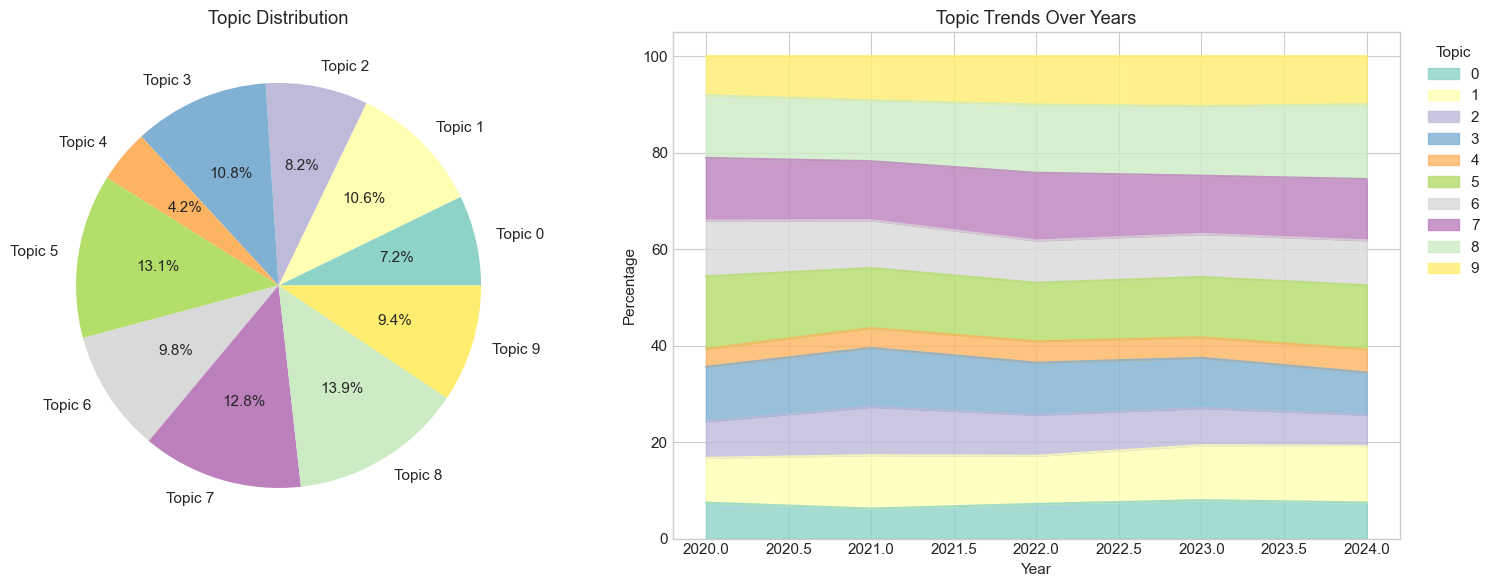

图表已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/lda_topic_distribution.png


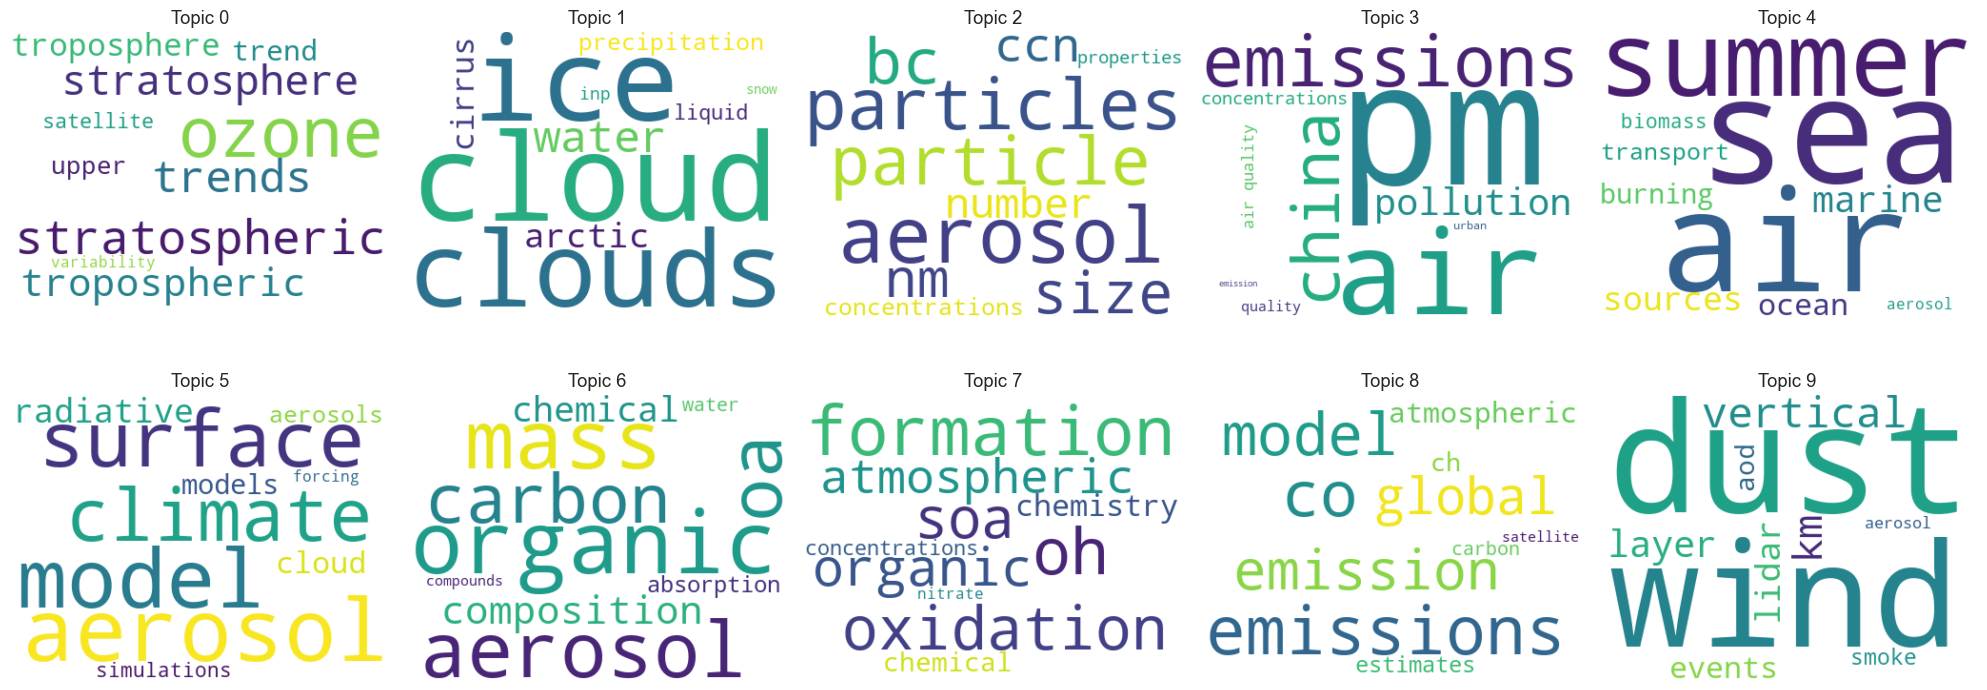

词云已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/lda_topic_wordclouds.png

关键词共现网络分析
Top 60 高频词已提取
网络节点数: 60
网络边数: 1765

Top 10 关键节点:
  aerosol: 1.0000
  temperature: 1.0000
  concentration: 1.0000
  summer: 1.0000
  number: 1.0000
  cloud: 1.0000
  formation: 1.0000
  particle: 1.0000
  layer: 1.0000
  china: 1.0000


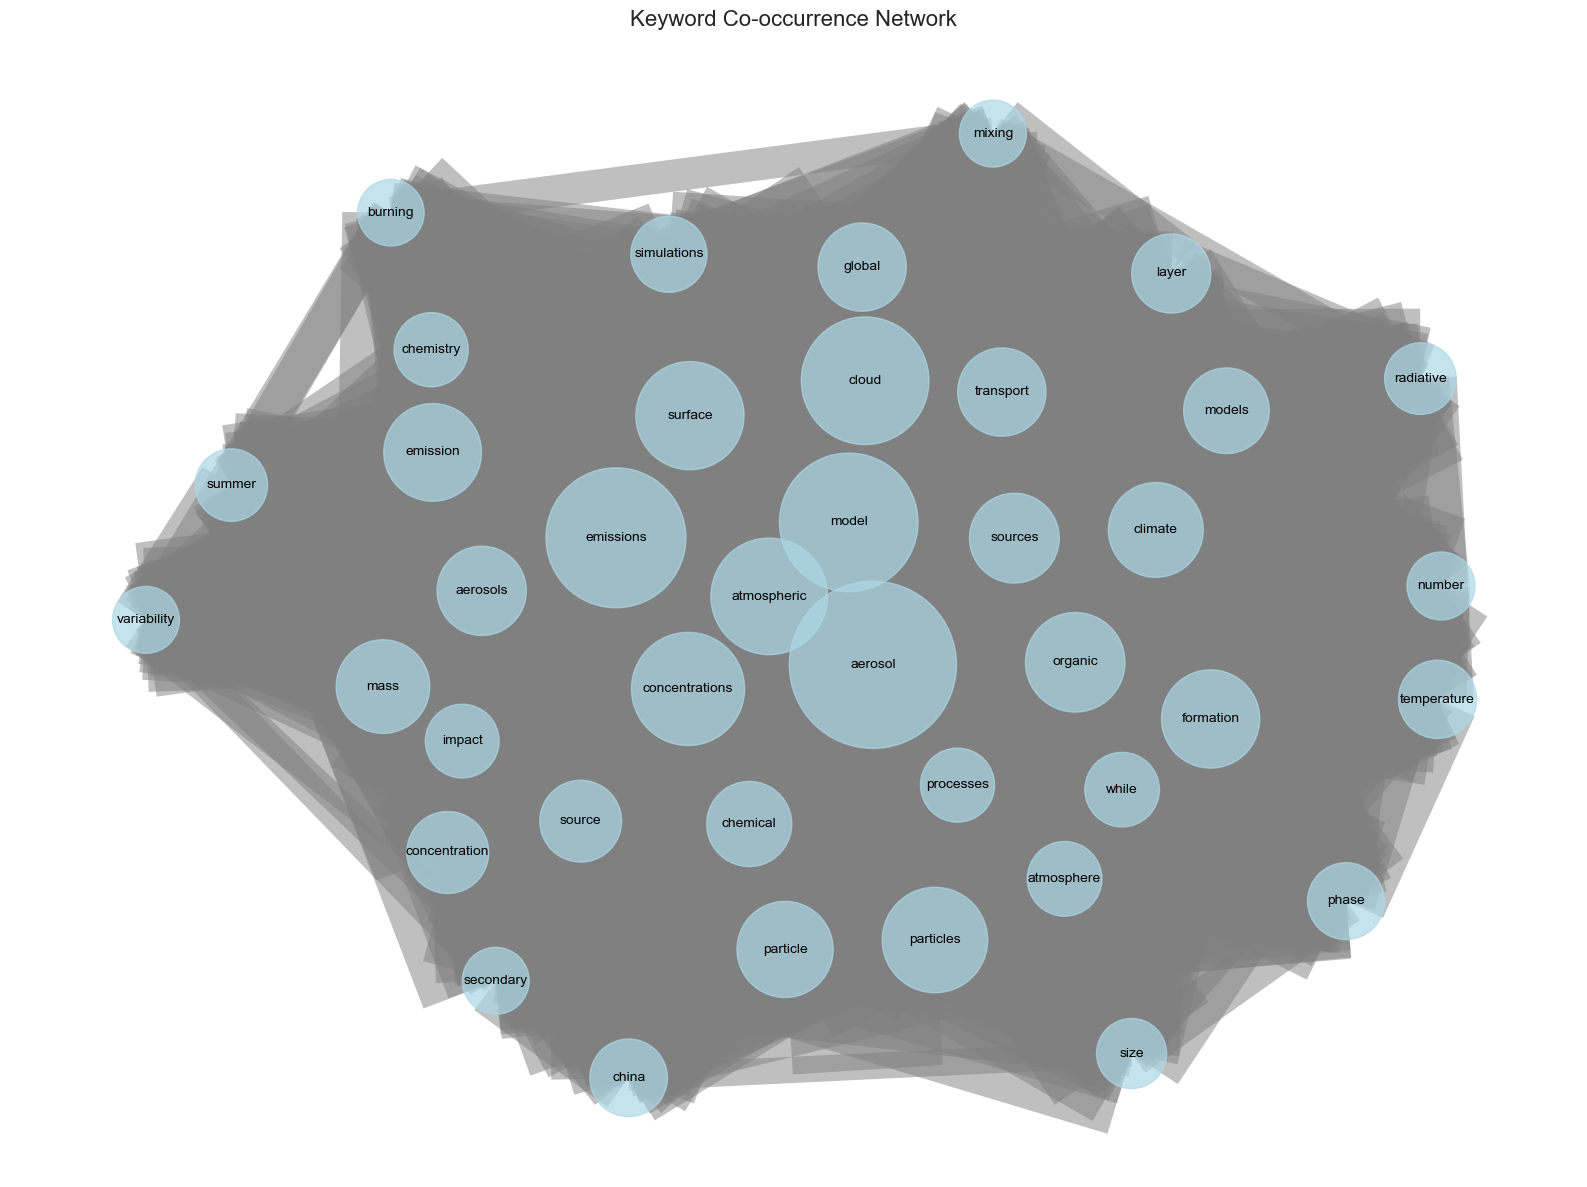

网络图已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/keyword_network.png

主题时间演化分析


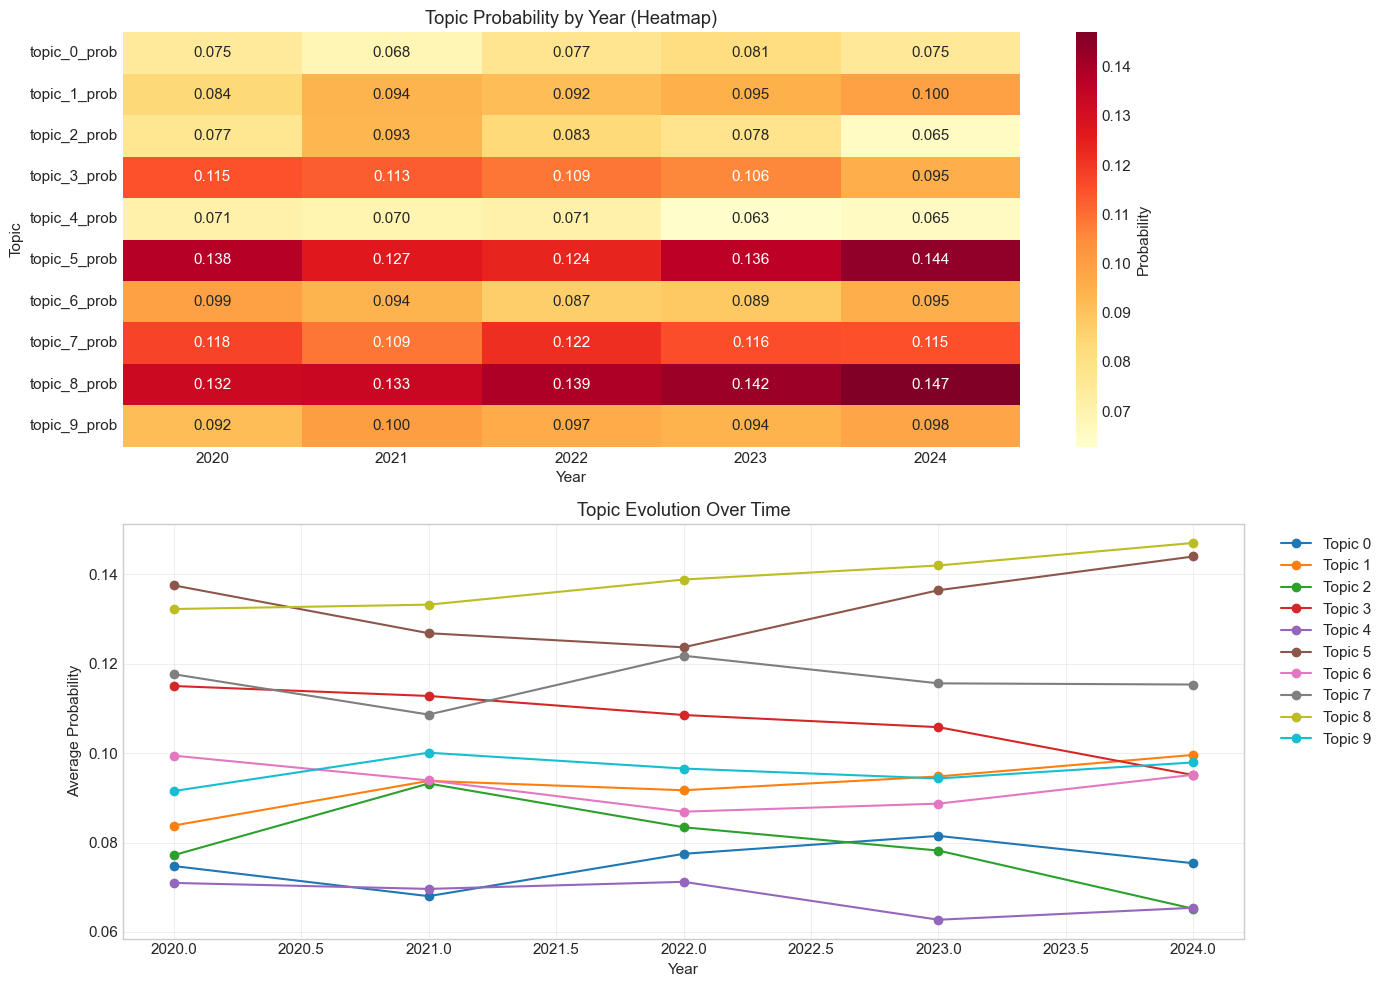

演化图已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/topic_evolution.png

主题趋势分析 (2020→2024):
  Topic 0: → 稳定 (+0.8%)
  Topic 1: ↑ 上升 (+18.9%)
  Topic 2: ↓ 下降 (-15.5%)
  Topic 3: ↓ 下降 (-17.3%)
  Topic 4: → 稳定 (-7.8%)
  Topic 5: → 稳定 (+4.7%)
  Topic 6: → 稳定 (-4.3%)
  Topic 7: → 稳定 (-2.0%)
  Topic 8: ↑ 上升 (+11.2%)
  Topic 9: → 稳定 (+7.0%)

研究类型分类

研究类型分布:
  Observational Study: 2394 (58.4%)
  Modeling Study: 1035 (25.2%)
  Remote Sensing: 257 (6.3%)
  Laboratory Study: 213 (5.2%)
  Data Analysis: 132 (3.2%)
  Other: 64 (1.6%)
  Review/Synthesis: 6 (0.1%)


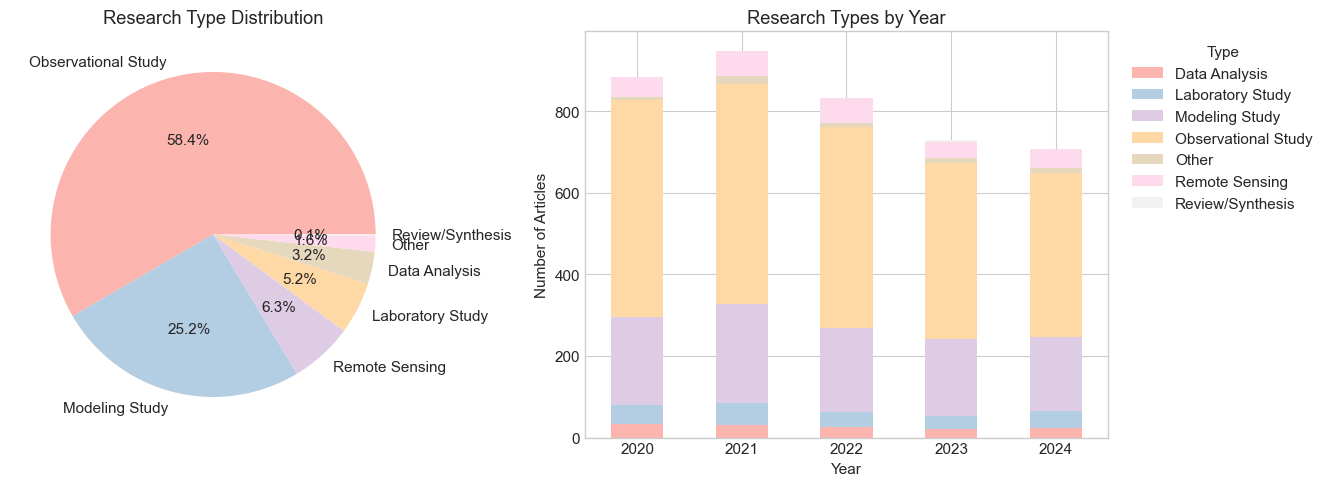

类型图已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/research_types.png

地理区域研究热点分析

区域研究分布:
  Global: 1481 篇 (36.1%)
  China: 871 篇 (21.2%)
  Europe: 734 篇 (17.9%)
  Arctic/Antarctic: 650 篇 (15.8%)
  North America: 408 篇 (9.9%)
  Atlantic: 288 篇 (7.0%)
  Africa: 282 篇 (6.9%)
  Pacific: 282 篇 (6.9%)
  India: 220 篇 (5.4%)
  Amazon: 142 篇 (3.5%)
  Southeast Asia: 88 篇 (2.1%)


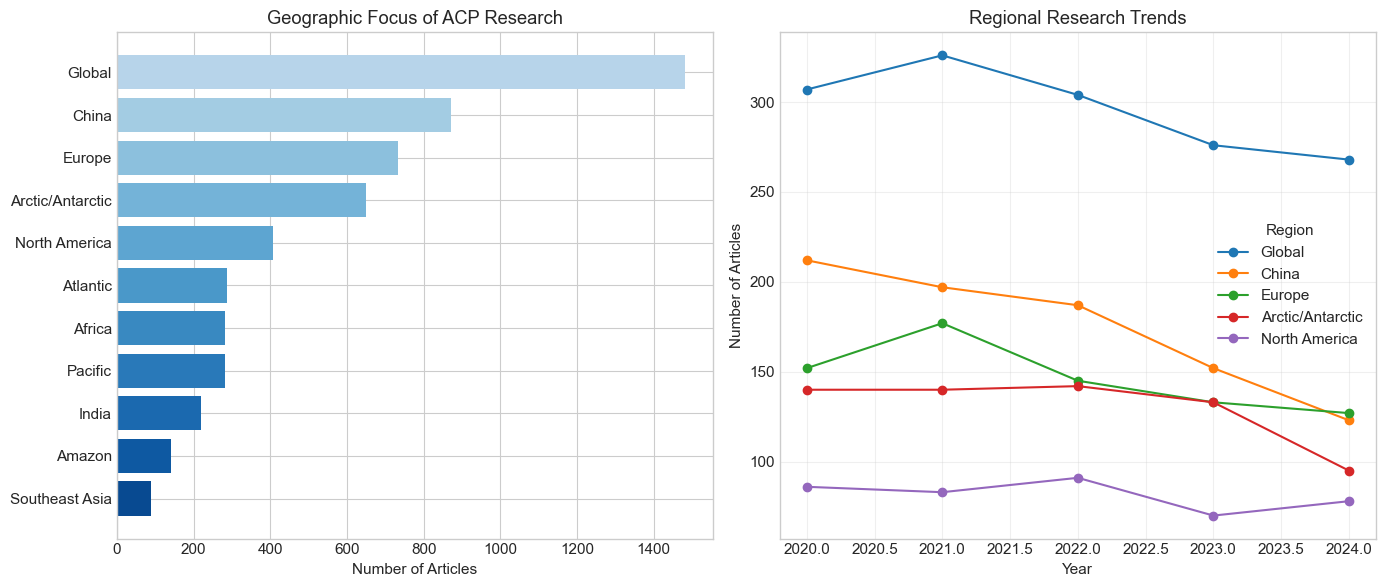

地理分析图已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/geographic_analysis.png

保存分析结果...
主题词已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/topics/lda_topics.csv
分析结果已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/analysis_results/articles_with_analysis.csv
网络文件已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/networks/keyword_network.gexf
主题演化数据已保存至: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/topics/topic_evolution.csv

分析完成！

输出文件汇总:

/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures/
├── lda_topic_distribution.png/pdf
├── lda_topic_wordclouds.png/pdf
├── topic_evolution.png/pdf
├── keyword_network.png/pdf
├── research_types.png/pdf
└── geographic_analysis.png/pdf

/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/analysis_results/
└── articles_with_analysis.csv

/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/topics/
├── lda_topics.csv
└── topic_evolution.csv

/Users/weiyingwan/Desktop/校内课程

In [6]:
"""
ACP Journal Deep Content Analysis
==================================
对ACP期刊Abstract进行深度内容分析

分析内容：
1. 主题建模 (LDA)
2. 关键词共现网络
3. 时间序列主题演化
4. 语义聚类分析
5. 研究方法分类
6. 地理/区域研究热点

运行环境：Jupyter Notebook / Python 3.8+
依赖包：pandas, numpy, sklearn, matplotlib, seaborn, networkx, wordcloud

作者：Claude Assistant
日期：2024年12月
"""

# =============================================================================
# Cell 1: 安装依赖
# =============================================================================
# !pip install pandas numpy scikit-learn matplotlib seaborn networkx wordcloud

# =============================================================================
# Cell 2: 导入库
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# NLP相关
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# 网络分析
import networkx as nx

# 词云
from wordcloud import WordCloud

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.unicode_minus'] = False

# ============================================================================
# 输出配置 - 使用用户指定的路径
# ============================================================================
BASE_OUTPUT_DIR = "/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract"

# 子目录结构
DATA_DIR = os.path.join(BASE_OUTPUT_DIR, "data")                    # 原始数据
ANALYSIS_DIR = os.path.join(BASE_OUTPUT_DIR, "analysis_results")    # 分析结果
FIGURE_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")               # 图表
NETWORK_DIR = os.path.join(BASE_OUTPUT_DIR, "networks")             # 网络文件
TOPIC_DIR = os.path.join(BASE_OUTPUT_DIR, "topics")                 # 主题分析

# 创建所有目录
for dir_path in [DATA_DIR, ANALYSIS_DIR, FIGURE_DIR, NETWORK_DIR, TOPIC_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print("库导入完成！")
print(f"\n输出目录结构:")
print(f"  基础目录: {BASE_OUTPUT_DIR}")
print(f"  数据目录: {DATA_DIR}")
print(f"  分析结果: {ANALYSIS_DIR}")
print(f"  图表目录: {FIGURE_DIR}")
print(f"  网络文件: {NETWORK_DIR}")
print(f"  主题分析: {TOPIC_DIR}")

# =============================================================================
# Cell 3: 加载数据
# =============================================================================

def load_abstract_data(filepath=None):
    """加载包含Abstract的数据"""
    
    # 如果没有指定路径，尝试从默认数据目录加载
    if filepath is None:
        # 查找data目录下最新的csv文件
        csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
        if csv_files:
            filepath = os.path.join(DATA_DIR, sorted(csv_files)[-1])
            print(f"自动选择最新数据文件: {filepath}")
        else:
            raise FileNotFoundError(f"在 {DATA_DIR} 目录下未找到CSV文件")
    
    # 尝试不同格式
    if filepath.endswith('.json'):
        import json
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
    elif filepath.endswith('.xlsx'):
        df = pd.read_excel(filepath)
    else:
        df = pd.read_csv(filepath)
    
    # 确保有abstract列
    if 'abstract' not in df.columns:
        if 'description' in df.columns:
            df['abstract'] = df['description']
        else:
            raise ValueError("数据中没有abstract或description列")
    
    # 清理空值
    df = df[df['abstract'].notna() & (df['abstract'] != '')]
    df = df.reset_index(drop=True)
    
    print(f"数据加载完成: {len(df)} 条有效记录")
    print(f"Abstract平均长度: {df['abstract'].str.len().mean():.0f} 字符")
    
    return df

# =============================================================================
# Cell 4: 文本预处理
# =============================================================================

def preprocess_text(text):
    """文本预处理"""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


def get_stopwords():
    """获取扩展停用词表"""
    
    base_stopwords = set([
        'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
        'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
        'could', 'should', 'may', 'might', 'must', 'shall', 'can', 'need',
        'it', 'its', 'this', 'that', 'these', 'those', 'we', 'our', 'they',
        'their', 'which', 'who', 'where', 'when', 'what', 'how', 'why',
        'also', 'than', 'more', 'most', 'some', 'any', 'each', 'between',
        'into', 'through', 'during', 'before', 'after', 'above', 'below',
        'both', 'same', 'different', 'such', 'other', 'another', 'many',
        'much', 'few', 'less', 'least', 'only', 'very', 'just', 'even',
        'about', 'over', 'under', 'again', 'further', 'then', 'once',
        'here', 'there', 'all', 'no', 'not', 'nor', 'so', 'too',
    ])
    
    academic_stopwords = set([
        'study', 'studies', 'studied', 'research', 'results', 'result',
        'show', 'shows', 'showed', 'shown', 'find', 'found', 'findings',
        'using', 'used', 'based', 'however', 'therefore', 'thus', 'hence',
        'paper', 'article', 'work', 'data', 'analysis', 'method', 'methods',
        'approach', 'approaches', 'investigated', 'observed', 'observations',
        'measured', 'measurements', 'calculated', 'estimated', 'determined',
        'obtained', 'performed', 'conducted', 'presented', 'discussed',
        'compared', 'evaluated', 'assessed', 'examined', 'analyzed',
        'significant', 'significantly', 'important', 'particularly',
        'generally', 'typically', 'usually', 'often', 'well', 'high', 'low',
        'large', 'small', 'new', 'first', 'second', 'two', 'three',
        'several', 'various', 'different', 'similar', 'potential',
        'respectively', 'approximately', 'relatively', 'corresponding',
        'increase', 'increased', 'increases', 'decrease', 'decreased',
        'decreases', 'higher', 'lower', 'suggest', 'suggests', 'suggested',
        'indicate', 'indicates', 'indicated', 'associated', 'related',
        'due', 'mainly', 'overall', 'total', 'average', 'mean', 'values',
        'range', 'ranging', 'ranges', 'level', 'levels', 'effect', 'effects',
        'factor', 'factors', 'conditions', 'condition', 'period', 'periods',
        'time', 'times', 'day', 'days', 'year', 'years', 'month', 'months',
        'region', 'regions', 'area', 'areas', 'site', 'sites', 'location',
        'order', 'magnitude', 'variation', 'variations', 'changes', 'change',
    ])
    
    return base_stopwords | academic_stopwords


# =============================================================================
# Cell 5: 主题建模 (LDA)
# =============================================================================

def perform_lda_analysis(df, n_topics=10, n_top_words=15):
    """执行LDA主题建模"""
    print("=" * 60)
    print("LDA主题建模分析")
    print("=" * 60)
    
    texts = df['abstract'].apply(preprocess_text).tolist()
    stopwords = list(get_stopwords())
    
    vectorizer = CountVectorizer(
        max_df=0.8,
        min_df=10,
        stop_words=stopwords,
        max_features=5000,
        ngram_range=(1, 2)
    )
    
    doc_term_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"词汇表大小: {len(feature_names)}")
    print(f"文档数: {doc_term_matrix.shape[0]}")
    
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=20,
        learning_method='online',
        random_state=42,
        n_jobs=-1
    )
    
    lda_output = lda.fit_transform(doc_term_matrix)
    
    topics = {}
    print(f"\n发现 {n_topics} 个主题:\n")
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f'Topic_{topic_idx}'] = top_words
        print(f"主题 {topic_idx}: {', '.join(top_words[:8])}...")
    
    df['dominant_topic'] = lda_output.argmax(axis=1)
    df['topic_probability'] = lda_output.max(axis=1)
    
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    print("\n主题分布:")
    for topic, count in topic_counts.items():
        print(f"  主题 {topic}: {count} 篇 ({count/len(df)*100:.1f}%)")
    
    return lda, vectorizer, lda_output, topics


def visualize_topics(lda, vectorizer, lda_output, topics, df):
    """可视化主题分析结果"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    colors = plt.cm.Set3(np.linspace(0, 1, len(topic_counts)))
    
    axes[0].pie(topic_counts.values, labels=[f'Topic {i}' for i in topic_counts.index],
                autopct='%1.1f%%', colors=colors)
    axes[0].set_title('Topic Distribution')
    
    if 'year' in df.columns:
        topic_year = pd.crosstab(df['year'], df['dominant_topic'])
        topic_year_pct = topic_year.div(topic_year.sum(axis=1), axis=0) * 100
        
        topic_year_pct.plot(kind='area', stacked=True, ax=axes[1], 
                            colormap='Set3', alpha=0.8)
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Percentage')
        axes[1].set_title('Topic Trends Over Years')
        axes[1].legend(title='Topic', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, 'lda_topic_distribution.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIGURE_DIR, 'lda_topic_distribution.pdf'), bbox_inches='tight')
    plt.show()
    print(f"图表已保存至: {FIGURE_DIR}/lda_topic_distribution.png")
    
    # 主题词云
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for topic_idx, (topic_name, words) in enumerate(topics.items()):
        if topic_idx >= 10:
            break
        
        word_freq = {word: 10-i for i, word in enumerate(words[:10])}
        wc = WordCloud(width=400, height=300, background_color='white', colormap='viridis')
        wc.generate_from_frequencies(word_freq)
        
        axes[topic_idx].imshow(wc, interpolation='bilinear')
        axes[topic_idx].set_title(f'Topic {topic_idx}')
        axes[topic_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, 'lda_topic_wordclouds.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIGURE_DIR, 'lda_topic_wordclouds.pdf'), bbox_inches='tight')
    plt.show()
    print(f"词云已保存至: {FIGURE_DIR}/lda_topic_wordclouds.png")


# =============================================================================
# Cell 6: 关键词共现网络
# =============================================================================

def build_cooccurrence_network(df, top_n=50, min_cooccurrence=5):
    """构建关键词共现网络"""
    print("\n" + "=" * 60)
    print("关键词共现网络分析")
    print("=" * 60)
    
    stopwords = get_stopwords()
    
    all_words = []
    doc_words = []
    
    for abstract in df['abstract']:
        if not isinstance(abstract, str):
            doc_words.append([])
            continue
        
        text = preprocess_text(abstract)
        words = [w for w in text.split() if len(w) > 2 and w not in stopwords]
        doc_words.append(words)
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    top_words = [word for word, count in word_counts.most_common(top_n)]
    top_words_set = set(top_words)
    
    print(f"Top {top_n} 高频词已提取")
    
    cooccurrence = defaultdict(int)
    
    for words in doc_words:
        words_in_doc = [w for w in set(words) if w in top_words_set]
        for i, w1 in enumerate(words_in_doc):
            for w2 in words_in_doc[i+1:]:
                pair = tuple(sorted([w1, w2]))
                cooccurrence[pair] += 1
    
    G = nx.Graph()
    
    for (w1, w2), count in cooccurrence.items():
        if count >= min_cooccurrence:
            G.add_edge(w1, w2, weight=count)
    
    print(f"网络节点数: {G.number_of_nodes()}")
    print(f"网络边数: {G.number_of_edges()}")
    
    if G.number_of_nodes() > 0:
        degree_centrality = nx.degree_centrality(G)
        print("\nTop 10 关键节点:")
        for word, score in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"  {word}: {score:.4f}")
    
    return G, word_counts


def visualize_network(G, word_counts, top_n=40):
    """可视化共现网络"""
    
    if G.number_of_nodes() == 0:
        print("网络为空，无法可视化")
        return
    
    degrees = dict(G.degree())
    nodes_to_keep = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:top_n]
    G_sub = G.subgraph(nodes_to_keep)
    
    plt.figure(figsize=(16, 12))
    
    node_sizes = [word_counts.get(node, 10) * 2 for node in G_sub.nodes()]
    edge_weights = [G_sub[u][v]['weight'] * 0.3 for u, v in G_sub.edges()]
    
    pos = nx.spring_layout(G_sub, k=2, iterations=50, seed=42)
    
    nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G_sub, pos, width=edge_weights, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G_sub, pos, font_size=10)
    
    plt.title('Keyword Co-occurrence Network', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, 'keyword_network.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIGURE_DIR, 'keyword_network.pdf'), bbox_inches='tight')
    plt.show()
    print(f"网络图已保存至: {FIGURE_DIR}/keyword_network.png")


# =============================================================================
# Cell 7: 时间序列主题演化
# =============================================================================

def analyze_topic_evolution(df, lda_output, n_topics=10):
    """分析主题随时间的演化"""
    print("\n" + "=" * 60)
    print("主题时间演化分析")
    print("=" * 60)
    
    if 'year' not in df.columns:
        print("数据中没有year列，无法进行时间演化分析")
        return None
    
    df_temp = df.copy()
    for i in range(n_topics):
        df_temp[f'topic_{i}_prob'] = lda_output[:, i]
    
    yearly_topics = df_temp.groupby('year')[[f'topic_{i}_prob' for i in range(n_topics)]].mean()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    sns.heatmap(yearly_topics.T, annot=True, fmt='.3f', cmap='YlOrRd',
                ax=axes[0], cbar_kws={'label': 'Probability'})
    axes[0].set_title('Topic Probability by Year (Heatmap)')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Topic')
    
    for i in range(n_topics):
        axes[1].plot(yearly_topics.index, yearly_topics[f'topic_{i}_prob'], marker='o', label=f'Topic {i}')
    
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Average Probability')
    axes[1].set_title('Topic Evolution Over Time')
    axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, 'topic_evolution.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIGURE_DIR, 'topic_evolution.pdf'), bbox_inches='tight')
    plt.show()
    print(f"演化图已保存至: {FIGURE_DIR}/topic_evolution.png")
    
    print("\n主题趋势分析 (2020→2024):")
    for i in range(n_topics):
        col = f'topic_{i}_prob'
        if len(yearly_topics) >= 2:
            start_val = yearly_topics[col].iloc[0]
            end_val = yearly_topics[col].iloc[-1]
            change = (end_val - start_val) / start_val * 100 if start_val > 0 else 0
            trend = "↑ 上升" if change > 10 else "↓ 下降" if change < -10 else "→ 稳定"
            print(f"  Topic {i}: {trend} ({change:+.1f}%)")
    
    return yearly_topics


# =============================================================================
# Cell 8: 研究方法/类型分类
# =============================================================================

def classify_research_type(df):
    """基于关键词自动分类研究类型"""
    print("\n" + "=" * 60)
    print("研究类型分类")
    print("=" * 60)
    
    research_types = {
        'Observational Study': ['observation', 'observed', 'campaign', 'field', 'in situ',
                                'measurement', 'measured', 'monitoring', 'station'],
        'Modeling Study': ['model', 'modeled', 'modelling', 'simulation', 'simulated',
                          'wrf', 'cmaq', 'geos-chem', 'cam', 'cesm', 'numerical'],
        'Remote Sensing': ['satellite', 'remote sensing', 'lidar', 'radar', 'retrieval',
                          'modis', 'calipso', 'omi', 'tropomi', 'sentinel', 'goes'],
        'Laboratory Study': ['laboratory', 'chamber', 'smog chamber', 'reaction', 
                            'kinetic', 'synthesis', 'experiment'],
        'Data Analysis': ['reanalysis', 'dataset', 'database', 'long-term', 'trend',
                         'statistical', 'machine learning', 'deep learning'],
        'Review/Synthesis': ['review', 'synthesis', 'overview', 'assessment', 'intercomparison']
    }
    
    def classify(abstract):
        if not isinstance(abstract, str):
            return 'Other'
        
        text = abstract.lower()
        matches = {}
        
        for rtype, keywords in research_types.items():
            count = sum(1 for kw in keywords if kw in text)
            if count > 0:
                matches[rtype] = count
        
        return max(matches, key=matches.get) if matches else 'Other'
    
    df['research_type'] = df['abstract'].apply(classify)
    
    type_counts = df['research_type'].value_counts()
    print("\n研究类型分布:")
    for rtype, count in type_counts.items():
        print(f"  {rtype}: {count} ({count/len(df)*100:.1f}%)")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(type_counts)))
    axes[0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors)
    axes[0].set_title('Research Type Distribution')
    
    if 'year' in df.columns:
        type_year = pd.crosstab(df['year'], df['research_type'])
        type_year.plot(kind='bar', stacked=True, ax=axes[1], colormap='Pastel1')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Number of Articles')
        axes[1].set_title('Research Types by Year')
        axes[1].legend(title='Type', bbox_to_anchor=(1.02, 1))
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, 'research_types.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIGURE_DIR, 'research_types.pdf'), bbox_inches='tight')
    plt.show()
    print(f"类型图已保存至: {FIGURE_DIR}/research_types.png")
    
    return df


# =============================================================================
# Cell 9: 地理/区域研究热点
# =============================================================================

def analyze_geographic_focus(df):
    """分析研究的地理区域分布"""
    print("\n" + "=" * 60)
    print("地理区域研究热点分析")
    print("=" * 60)
    
    regions = {
        'China': ['china', 'chinese', 'beijing', 'shanghai', 'guangzhou', 
                  'nanjing', 'chengdu', 'pearl river delta', 'yangtze'],
        'Europe': ['europe', 'european', 'germany', 'france', 'uk', 'spain',
                   'italy', 'mediterranean', 'alps', 'scandina'],
        'North America': ['united states', 'usa', 'american', 'canada', 
                          'california', 'texas', 'new york', 'mexico'],
        'Southeast Asia': ['southeast asia', 'indonesia', 'malaysia', 'thailand',
                           'vietnam', 'philippines', 'singapore', 'borneo'],
        'India': ['india', 'indian', 'delhi', 'mumbai', 'ganges', 'himalaya'],
        'Arctic/Antarctic': ['arctic', 'antarctic', 'polar', 'greenland', 'svalbard', 'alaska'],
        'Africa': ['africa', 'african', 'sahara', 'sahel', 'nigeria', 'south africa'],
        'Amazon': ['amazon', 'brazil', 'south america', 'tropical forest'],
        'Pacific': ['pacific', 'pacific ocean', 'hawaii', 'japan', 'korea'],
        'Atlantic': ['atlantic', 'atlantic ocean', 'caribbean'],
        'Global': ['global', 'worldwide', 'earth', 'planetary']
    }
    
    region_counts = {region: 0 for region in regions}
    region_articles = {region: [] for region in regions}
    
    for idx, row in df.iterrows():
        abstract = str(row.get('abstract', '')).lower()
        title = str(row.get('title', '')).lower()
        text = abstract + ' ' + title
        
        for region, keywords in regions.items():
            if any(kw in text for kw in keywords):
                region_counts[region] += 1
                region_articles[region].append(idx)
    
    print("\n区域研究分布:")
    for region, count in sorted(region_counts.items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            print(f"  {region}: {count} 篇 ({count/len(df)*100:.1f}%)")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sorted_regions = [(r, c) for r, c in sorted(region_counts.items(), key=lambda x: x[1], reverse=True) if c > 0]
    regions_list = [r for r, c in sorted_regions]
    counts_list = [c for r, c in sorted_regions]
    
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(regions_list)))
    axes[0].barh(regions_list, counts_list, color=colors)
    axes[0].set_xlabel('Number of Articles')
    axes[0].set_title('Geographic Focus of ACP Research')
    axes[0].invert_yaxis()
    
    if 'year' in df.columns:
        top_regions = regions_list[:5]
        yearly_data = []
        for year in sorted(df['year'].unique()):
            year_df = df[df['year'] == year]
            row = {'year': year}
            for region in top_regions:
                count = sum(1 for idx in region_articles[region] if idx < len(df) and df.loc[idx, 'year'] == year)
                row[region] = count
            yearly_data.append(row)
        
        yearly_df = pd.DataFrame(yearly_data).set_index('year')
        yearly_df.plot(kind='line', marker='o', ax=axes[1])
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Number of Articles')
        axes[1].set_title('Regional Research Trends')
        axes[1].legend(title='Region')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, 'geographic_analysis.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIGURE_DIR, 'geographic_analysis.pdf'), bbox_inches='tight')
    plt.show()
    print(f"地理分析图已保存至: {FIGURE_DIR}/geographic_analysis.png")
    
    return region_counts


# =============================================================================
# Cell 10: 主程序
# =============================================================================

def run_complete_analysis(df):
    """运行完整的深度分析"""
    
    print("=" * 70)
    print("ACP期刊深度内容分析")
    print(f"分析时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 70)
    
    print(f"\n数据概览: {len(df)} 篇文章")
    if 'year' in df.columns:
        print(f"时间范围: {df['year'].min()} - {df['year'].max()}")
    
    # 1. LDA主题建模
    lda, vectorizer, lda_output, topics = perform_lda_analysis(df, n_topics=10)
    visualize_topics(lda, vectorizer, lda_output, topics, df)
    
    # 2. 关键词共现网络
    G, word_counts = build_cooccurrence_network(df, top_n=60, min_cooccurrence=10)
    visualize_network(G, word_counts)
    
    # 3. 主题时间演化
    yearly_topics = analyze_topic_evolution(df, lda_output)
    
    # 4. 研究类型分类
    df = classify_research_type(df)
    
    # 5. 地理区域分析
    region_counts = analyze_geographic_focus(df)
    
    # 保存结果
    print("\n" + "=" * 60)
    print("保存分析结果...")
    print("=" * 60)
    
    # 主题词
    topics_df = pd.DataFrame(topics)
    topics_df.to_csv(os.path.join(TOPIC_DIR, 'lda_topics.csv'), index=False)
    print(f"主题词已保存至: {TOPIC_DIR}/lda_topics.csv")
    
    # 带标签的数据
    df.to_csv(os.path.join(ANALYSIS_DIR, 'articles_with_analysis.csv'), index=False)
    print(f"分析结果已保存至: {ANALYSIS_DIR}/articles_with_analysis.csv")
    
    # 网络文件
    if G.number_of_nodes() > 0:
        nx.write_gexf(G, os.path.join(NETWORK_DIR, 'keyword_network.gexf'))
        print(f"网络文件已保存至: {NETWORK_DIR}/keyword_network.gexf")
    
    # 主题演化数据
    if yearly_topics is not None:
        yearly_topics.to_csv(os.path.join(TOPIC_DIR, 'topic_evolution.csv'))
        print(f"主题演化数据已保存至: {TOPIC_DIR}/topic_evolution.csv")
    
    print("\n" + "=" * 60)
    print("分析完成！")
    print("=" * 60)
    print(f"""
输出文件汇总:

{FIGURE_DIR}/
├── lda_topic_distribution.png/pdf
├── lda_topic_wordclouds.png/pdf
├── topic_evolution.png/pdf
├── keyword_network.png/pdf
├── research_types.png/pdf
└── geographic_analysis.png/pdf

{ANALYSIS_DIR}/
└── articles_with_analysis.csv

{TOPIC_DIR}/
├── lda_topics.csv
└── topic_evolution.csv

{NETWORK_DIR}/
└── keyword_network.gexf (可用Gephi打开)
""")
    
    return {
        'lda': lda,
        'topics': topics,
        'network': G,
        'yearly_topics': yearly_topics,
        'region_counts': region_counts
    }


# =============================================================================
# Cell 11: 运行分析
# =============================================================================

print(f"""
使用说明：

1. 加载数据:
   df = load_abstract_data()  # 自动从data目录加载
   # 或指定路径:
   df = load_abstract_data('{DATA_DIR}/your_file.csv')

2. 运行完整分析:
   results = run_complete_analysis(df)

3. 或单独运行各分析模块:
   - perform_lda_analysis(df)
   - build_cooccurrence_network(df)
   - analyze_topic_evolution(df, lda_output)
   - classify_research_type(df)
   - analyze_geographic_focus(df)

输出目录: {BASE_OUTPUT_DIR}
""")

# 取消注释以运行:
df = load_abstract_data()
results = run_complete_analysis(df)

ACP期刊分析 - 学术期刊规范图表绑定
时间: 2025-12-19 21:17:30
学术期刊绑定风格已设置
已加载分析数据: 4101 条记录

绑定图1: 主题分布...


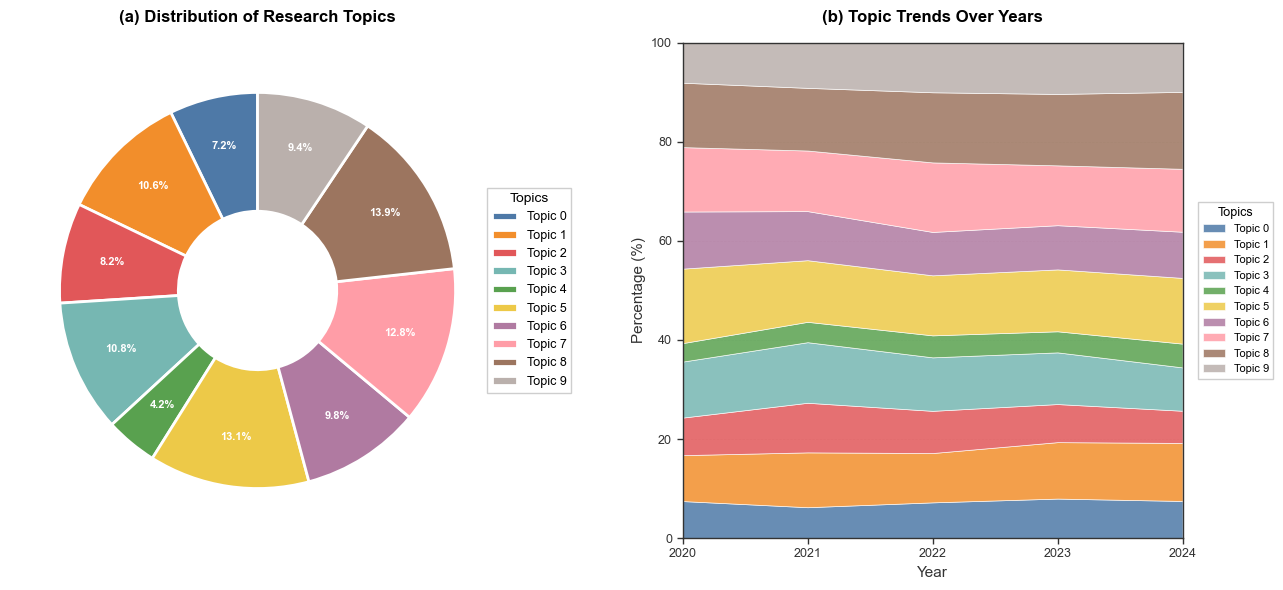

  已保存: Fig1_topic_distribution.png/pdf

绑定图2: 主题词云...


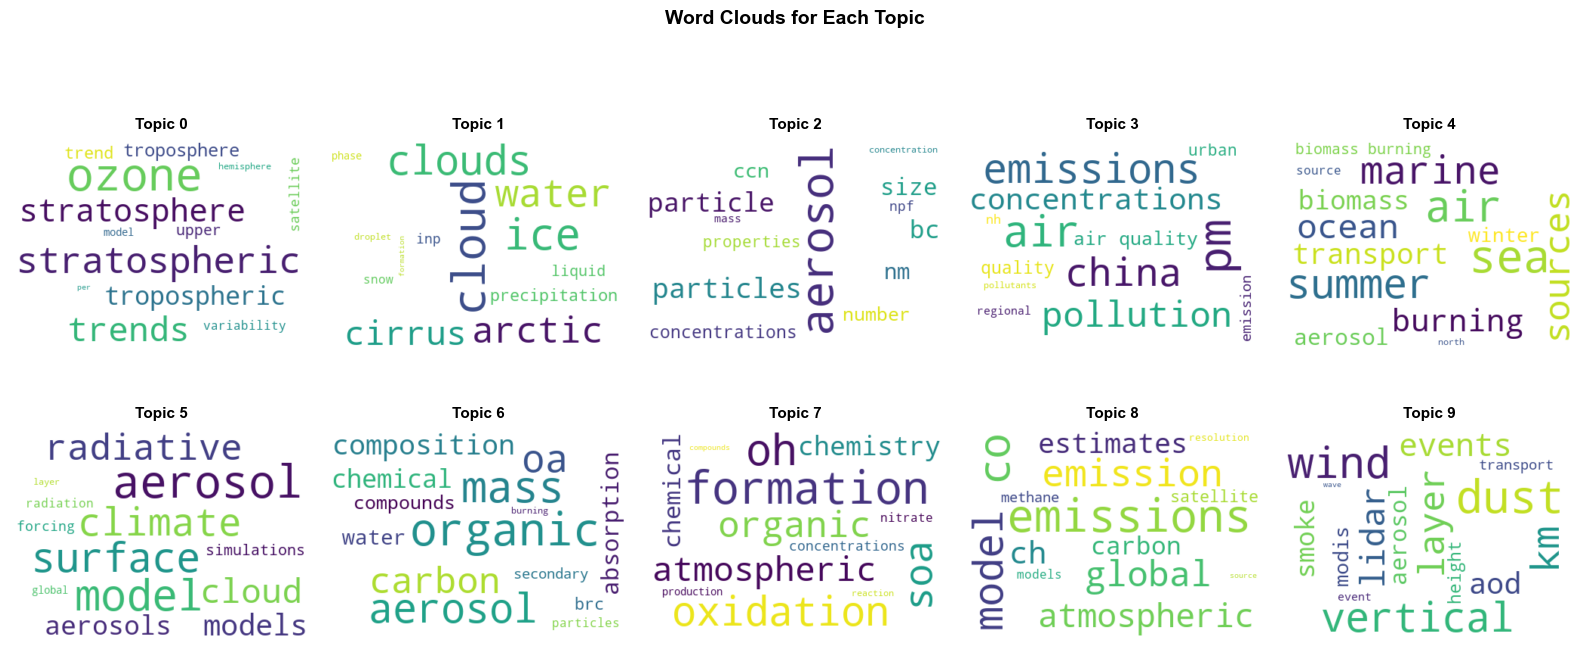

  已保存: Fig2_topic_wordclouds.png/pdf

绑定图3: 主题演化...


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

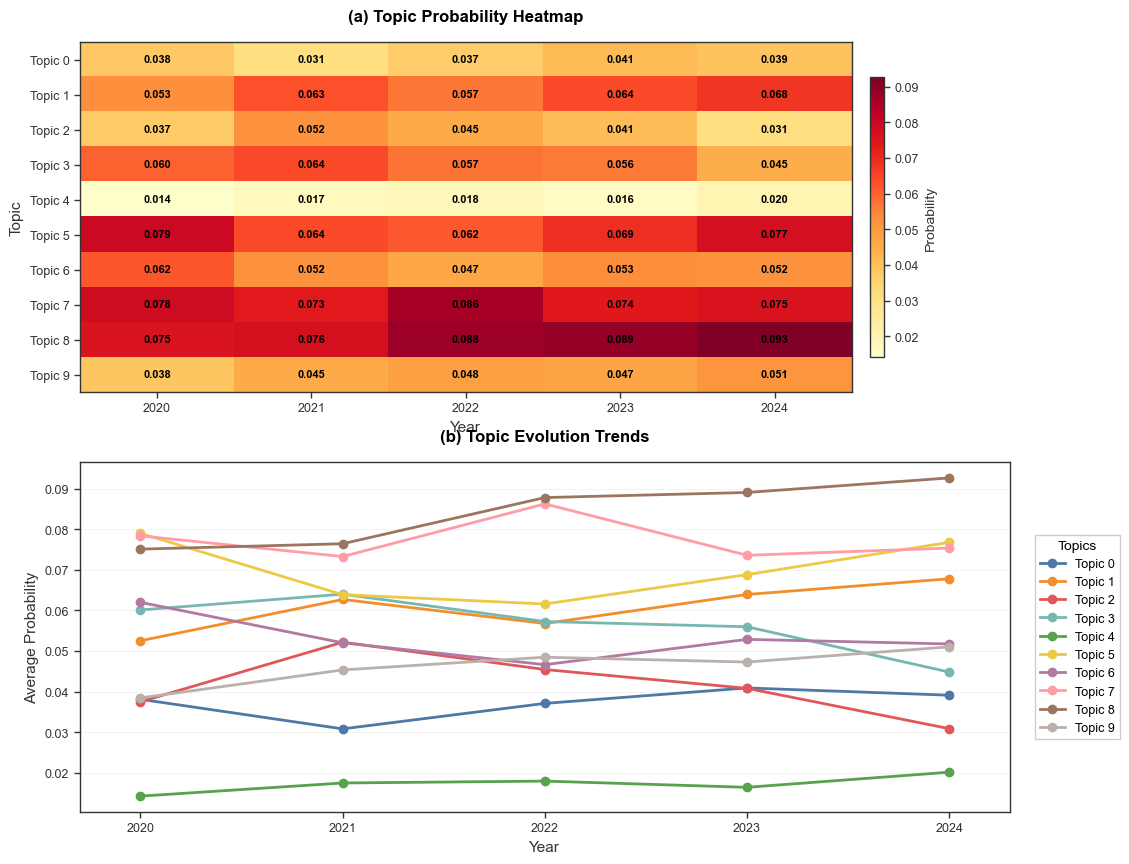

In [7]:
"""
ACP Journal Analysis - Publication-Quality Figures
===================================================
根据学术期刊绘图规范重新绘制所有图表

规范参考：
- 字体：Arial/Helvetica（无衬线）或Times New Roman（衬线）
- 分辨率：300-600 dpi
- 字号：标题12pt，轴标签10-11pt，刻度8-9pt
- 配色：色盲友好配色方案
- 布局：充足边距，无文字遮挡

作者：Claude Assistant
日期：2024年12月
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
import seaborn as sns
from collections import Counter, defaultdict
import re
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# NLP相关
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 网络分析
import networkx as nx

# 词云
from wordcloud import WordCloud

# =============================================================================
# 全局绑定配置 - 学术期刊标准
# =============================================================================

# 输出目录
BASE_OUTPUT_DIR = "/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract"
FIGURE_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
DATA_DIR = os.path.join(BASE_OUTPUT_DIR, "data")
ANALYSIS_DIR = os.path.join(BASE_OUTPUT_DIR, "analysis_results")
TOPIC_DIR = os.path.join(BASE_OUTPUT_DIR, "topics")
NETWORK_DIR = os.path.join(BASE_OUTPUT_DIR, "networks")

os.makedirs(FIGURE_DIR, exist_ok=True)

# =============================================================================
# 设置学术期刊绑定风格
# =============================================================================

def setup_publication_style():
    """设置符合学术期刊标准的绑定风格"""
    
    # 重置为默认设置
    plt.rcdefaults()
    
    # 学术期刊标准配置
    plt.rcParams.update({
        # 字体设置
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 10,
        
        # 各元素字号
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'legend.title_fontsize': 10,
        
        # 图表元素
        'axes.linewidth': 1.0,
        'axes.edgecolor': '#333333',
        'axes.labelcolor': '#333333',
        'xtick.color': '#333333',
        'ytick.color': '#333333',
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        
        # 网格
        'axes.grid': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.5,
        
        # 图例
        'legend.frameon': True,
        'legend.framealpha': 0.95,
        'legend.edgecolor': '#cccccc',
        'legend.fancybox': False,
        
        # 保存设置
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1,
        'figure.dpi': 100,
        
        # 布局
        'figure.constrained_layout.use': True,
        'figure.autolayout': False,
    })
    
    print("学术期刊绑定风格已设置")

# 学术配色方案（色盲友好）
COLORS = {
    'primary': '#2E86AB',      # 蓝色
    'secondary': '#A23B72',    # 紫红色
    'accent1': '#F18F01',      # 橙色
    'accent2': '#C73E1D',      # 红色
    'accent3': '#3B1F2B',      # 深色
    'neutral': '#95969A',      # 灰色
    'light': '#E8E8E8',        # 浅灰
}

# 10色调色板（用于主题）- 色盲友好
TOPIC_COLORS = [
    '#4E79A7',  # 蓝
    '#F28E2B',  # 橙
    '#E15759',  # 红
    '#76B7B2',  # 青
    '#59A14F',  # 绿
    '#EDC948',  # 黄
    '#B07AA1',  # 紫
    '#FF9DA7',  # 粉
    '#9C755F',  # 棕
    '#BAB0AC',  # 灰
]

# 研究类型配色
TYPE_COLORS = {
    'Observational Study': '#4E79A7',
    'Modeling Study': '#F28E2B',
    'Remote Sensing': '#E15759',
    'Laboratory Study': '#76B7B2',
    'Data Analysis': '#59A14F',
    'Review/Synthesis': '#EDC948',
    'Other': '#BAB0AC',
}

# =============================================================================
# 数据加载和预处理
# =============================================================================

def load_data():
    """加载数据"""
    # 尝试加载带分析结果的数据
    analysis_file = os.path.join(ANALYSIS_DIR, 'articles_with_analysis.csv')
    if os.path.exists(analysis_file):
        df = pd.read_csv(analysis_file)
        print(f"已加载分析数据: {len(df)} 条记录")
        return df
    
    # 否则加载原始数据
    csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
    if csv_files:
        filepath = os.path.join(DATA_DIR, sorted(csv_files)[-1])
        df = pd.read_csv(filepath)
        print(f"已加载原始数据: {len(df)} 条记录")
        return df
    
    raise FileNotFoundError("未找到数据文件")


def preprocess_text(text):
    """文本预处理"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def get_stopwords():
    """获取停用词"""
    base = set(['a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
                'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
                'could', 'should', 'may', 'might', 'must', 'shall', 'can', 'need',
                'it', 'its', 'this', 'that', 'these', 'those', 'we', 'our', 'they',
                'their', 'which', 'who', 'where', 'when', 'what', 'how', 'why',
                'also', 'than', 'more', 'most', 'some', 'any', 'each', 'between',
                'into', 'through', 'during', 'before', 'after', 'above', 'below',
                'both', 'same', 'different', 'such', 'other', 'another', 'many',
                'much', 'few', 'less', 'least', 'only', 'very', 'just', 'even',
                'about', 'over', 'under', 'again', 'further', 'then', 'once',
                'here', 'there', 'all', 'no', 'not', 'nor', 'so', 'too'])
    
    academic = set(['study', 'studies', 'studied', 'research', 'results', 'result',
                   'show', 'shows', 'showed', 'shown', 'find', 'found', 'findings',
                   'using', 'used', 'based', 'however', 'therefore', 'thus', 'hence',
                   'paper', 'article', 'work', 'data', 'analysis', 'method', 'methods',
                   'approach', 'investigated', 'observed', 'observations', 'measured',
                   'measurements', 'calculated', 'estimated', 'determined', 'obtained',
                   'performed', 'conducted', 'presented', 'discussed', 'compared',
                   'evaluated', 'assessed', 'examined', 'analyzed', 'significant',
                   'significantly', 'important', 'particularly', 'generally', 'typically',
                   'usually', 'often', 'well', 'high', 'low', 'large', 'small', 'new',
                   'first', 'second', 'two', 'three', 'several', 'various', 'similar',
                   'potential', 'respectively', 'approximately', 'relatively',
                   'increase', 'increased', 'decrease', 'decreased', 'higher', 'lower',
                   'suggest', 'suggests', 'indicate', 'indicates', 'associated', 'related',
                   'due', 'mainly', 'overall', 'total', 'average', 'mean', 'values',
                   'range', 'level', 'levels', 'effect', 'effects', 'factor', 'factors',
                   'conditions', 'period', 'time', 'day', 'days', 'year', 'years',
                   'region', 'regions', 'area', 'areas', 'site', 'sites', 'order',
                   'magnitude', 'variation', 'variations', 'changes', 'change'])
    
    return base | academic


# =============================================================================
# 图1: 主题分布（双面板）
# =============================================================================

def plot_topic_distribution(df, lda_output, n_topics=10):
    """绑定主题分布 - 饼图和堆叠面积图"""
    
    print("\n绑定图1: 主题分布...")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- 左侧: 环形图（比饼图更现代） ---
    ax1 = axes[0]
    
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    
    # 创建环形图
    wedges, texts, autotexts = ax1.pie(
        topic_counts.values,
        labels=None,  # 不在图上直接标注
        autopct='%1.1f%%',
        colors=TOPIC_COLORS[:len(topic_counts)],
        wedgeprops=dict(width=0.6, edgecolor='white', linewidth=2),
        pctdistance=0.75,
        startangle=90
    )
    
    # 设置百分比文字
    for autotext in autotexts:
        autotext.set_fontsize(8)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    # 添加图例（放在右侧）
    ax1.legend(
        wedges,
        [f'Topic {i}' for i in topic_counts.index],
        title='Topics',
        loc='center left',
        bbox_to_anchor=(0.95, 0.5),
        fontsize=9,
        title_fontsize=10
    )
    
    ax1.set_title('(a) Distribution of Research Topics', fontsize=12, fontweight='bold', pad=15)
    
    # --- 右侧: 堆叠面积图 ---
    ax2 = axes[1]
    
    if 'year' in df.columns:
        # 计算每年各主题的数量
        topic_year = pd.crosstab(df['year'], df['dominant_topic'])
        topic_year_pct = topic_year.div(topic_year.sum(axis=1), axis=0) * 100
        
        # 绑定堆叠面积图
        years = topic_year_pct.index.values
        
        ax2.stackplot(
            years,
            [topic_year_pct[i].values for i in range(n_topics)],
            labels=[f'Topic {i}' for i in range(n_topics)],
            colors=TOPIC_COLORS[:n_topics],
            alpha=0.85,
            edgecolor='white',
            linewidth=0.5
        )
        
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Percentage (%)', fontsize=11)
        ax2.set_xlim(years.min(), years.max())
        ax2.set_ylim(0, 100)
        ax2.set_xticks(years)
        
        # 图例放在图外右侧
        ax2.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=8,
            title='Topics',
            title_fontsize=9,
            frameon=True
        )
        
        # 添加网格
        ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax2.set_axisbelow(True)
    
    ax2.set_title('(b) Topic Trends Over Years', fontsize=12, fontweight='bold', pad=15)
    
    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35, right=0.85)
    
    # 保存
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig1_topic_distribution.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig1_topic_distribution.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"  已保存: Fig1_topic_distribution.png/pdf")


# =============================================================================
# 图2: 主题词云（2x5网格）
# =============================================================================

def plot_topic_wordclouds(topics, n_topics=10):
    """绑定主题词云"""
    
    print("\n绑定图2: 主题词云...")
    
    fig, axes = plt.subplots(2, 5, figsize=(16, 7))
    axes = axes.flatten()
    
    for topic_idx in range(n_topics):
        ax = axes[topic_idx]
        
        topic_name = f'Topic_{topic_idx}'
        if topic_name in topics:
            words = topics[topic_name]
            # 创建词频字典（权重递减）
            word_freq = {word: (15-i)**1.5 for i, word in enumerate(words[:15])}
            
            # 创建词云
            wc = WordCloud(
                width=400,
                height=280,
                background_color='white',
                colormap='viridis',
                max_words=15,
                prefer_horizontal=0.8,
                min_font_size=10,
                max_font_size=60,
                relative_scaling=0.5,
                margin=10
            )
            wc.generate_from_frequencies(word_freq)
            
            ax.imshow(wc, interpolation='bilinear')
        
        ax.set_title(f'Topic {topic_idx}', fontsize=11, fontweight='bold', pad=8)
        ax.axis('off')
        
        # 添加边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#cccccc')
            spine.set_linewidth(1)
    
    plt.suptitle('Word Clouds for Each Topic', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig2_topic_wordclouds.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig2_topic_wordclouds.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"  已保存: Fig2_topic_wordclouds.png/pdf")


# =============================================================================
# 图3: 主题演化（热力图 + 折线图）
# =============================================================================

def plot_topic_evolution(df, lda_output, n_topics=10):
    """绑定主题时间演化"""
    
    print("\n绑定图3: 主题演化...")
    
    if 'year' not in df.columns:
        print("  无year列，跳过")
        return None
    
    # 计算每年各主题的平均概率
    df_temp = df.copy()
    for i in range(n_topics):
        df_temp[f'topic_{i}_prob'] = lda_output[:, i]
    
    yearly_topics = df_temp.groupby('year')[[f'topic_{i}_prob' for i in range(n_topics)]].mean()
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # --- 上方: 热力图 ---
    ax1 = axes[0]
    
    # 准备热力图数据
    heatmap_data = yearly_topics.T.values
    
    im = ax1.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
    
    # 设置刻度
    ax1.set_xticks(range(len(yearly_topics.index)))
    ax1.set_xticklabels(yearly_topics.index.astype(int))
    ax1.set_yticks(range(n_topics))
    ax1.set_yticklabels([f'Topic {i}' for i in range(n_topics)])
    
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel('Topic', fontsize=11)
    ax1.set_title('(a) Topic Probability Heatmap', fontsize=12, fontweight='bold', pad=15)
    
    # 添加数值标注
    for i in range(n_topics):
        for j in range(len(yearly_topics.index)):
            value = heatmap_data[i, j]
            text_color = 'white' if value > 0.12 else 'black'
            ax1.text(j, i, f'{value:.3f}', ha='center', va='center', 
                    fontsize=8, color=text_color, fontweight='bold')
    
    # 颜色条
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8, pad=0.02)
    cbar.set_label('Probability', fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    
    # --- 下方: 折线图 ---
    ax2 = axes[1]
    
    for i in range(n_topics):
        ax2.plot(
            yearly_topics.index,
            yearly_topics[f'topic_{i}_prob'],
            marker='o',
            markersize=6,
            linewidth=2,
            label=f'Topic {i}',
            color=TOPIC_COLORS[i]
        )
    
    ax2.set_xlabel('Year', fontsize=11)
    ax2.set_ylabel('Average Probability', fontsize=11)
    ax2.set_title('(b) Topic Evolution Trends', fontsize=12, fontweight='bold', pad=15)
    
    ax2.set_xticks(yearly_topics.index)
    ax2.set_xlim(yearly_topics.index.min() - 0.3, yearly_topics.index.max() + 0.3)
    
    # 网格
    ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax2.set_axisbelow(True)
    
    # 图例
    ax2.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=9,
        title='Topics',
        title_fontsize=10,
        frameon=True,
        ncol=1
    )
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, right=0.88)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig3_topic_evolution.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig3_topic_evolution.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"  已保存: Fig3_topic_evolution.png/pdf")
    
    return yearly_topics


# =============================================================================
# 图4: 关键词共现网络
# =============================================================================

def plot_keyword_network(df, top_n=50, min_cooccurrence=8):
    """绑定关键词共现网络"""
    
    print("\n绑定图4: 关键词网络...")
    
    stopwords = get_stopwords()
    
    # 提取词
    all_words = []
    doc_words = []
    
    for abstract in df['abstract']:
        if not isinstance(abstract, str):
            doc_words.append([])
            continue
        text = preprocess_text(abstract)
        words = [w for w in text.split() if len(w) > 2 and w not in stopwords]
        doc_words.append(words)
        all_words.extend(words)
    
    # 获取高频词
    word_counts = Counter(all_words)
    top_words = [word for word, count in word_counts.most_common(top_n)]
    top_words_set = set(top_words)
    
    # 计算共现
    cooccurrence = defaultdict(int)
    for words in doc_words:
        words_in_doc = [w for w in set(words) if w in top_words_set]
        for i, w1 in enumerate(words_in_doc):
            for w2 in words_in_doc[i+1:]:
                pair = tuple(sorted([w1, w2]))
                cooccurrence[pair] += 1
    
    # 构建网络
    G = nx.Graph()
    for (w1, w2), count in cooccurrence.items():
        if count >= min_cooccurrence:
            G.add_edge(w1, w2, weight=count)
    
    if G.number_of_nodes() == 0:
        print("  网络为空")
        return None, word_counts
    
    # 只保留度数较高的节点
    degrees = dict(G.degree())
    nodes_to_keep = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:40]
    G_sub = G.subgraph(nodes_to_keep).copy()
    
    # 绘图
    fig, ax = plt.subplots(figsize=(14, 11))
    
    # 布局
    pos = nx.spring_layout(G_sub, k=2.5, iterations=100, seed=42)
    
    # 节点大小基于词频
    node_sizes = [word_counts.get(node, 10) * 3 for node in G_sub.nodes()]
    
    # 节点颜色基于度
    node_degrees = [G_sub.degree(node) for node in G_sub.nodes()]
    
    # 边宽度
    edge_weights = [G_sub[u][v]['weight'] * 0.15 for u, v in G_sub.edges()]
    
    # 绘制边
    nx.draw_networkx_edges(
        G_sub, pos,
        width=edge_weights,
        alpha=0.4,
        edge_color='#888888',
        ax=ax
    )
    
    # 绘制节点
    nodes = nx.draw_networkx_nodes(
        G_sub, pos,
        node_size=node_sizes,
        node_color=node_degrees,
        cmap=plt.cm.YlOrRd,
        alpha=0.9,
        edgecolors='white',
        linewidths=1.5,
        ax=ax
    )
    
    # 绘制标签
    nx.draw_networkx_labels(
        G_sub, pos,
        font_size=9,
        font_weight='bold',
        font_color='#333333',
        ax=ax
    )
    
    # 颜色条
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label('Node Degree', fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    
    ax.set_title('Keyword Co-occurrence Network', fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    
    # 添加说明
    ax.text(0.02, 0.02, 
            'Node size: word frequency\nEdge width: co-occurrence frequency\nColor: node degree',
            transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#cccccc'))
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig4_keyword_network.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig4_keyword_network.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    # 保存网络文件
    nx.write_gexf(G, os.path.join(NETWORK_DIR, 'keyword_network.gexf'))
    
    print(f"  已保存: Fig4_keyword_network.png/pdf")
    print(f"  网络节点: {G_sub.number_of_nodes()}, 边: {G_sub.number_of_edges()}")
    
    return G, word_counts


# =============================================================================
# 图5: 研究类型分布
# =============================================================================

def plot_research_types(df):
    """绑定研究类型分布"""
    
    print("\n绑定图5: 研究类型...")
    
    # 分类
    research_types = {
        'Observational Study': ['observation', 'observed', 'campaign', 'field', 'in situ',
                                'measurement', 'measured', 'monitoring', 'station'],
        'Modeling Study': ['model', 'modeled', 'modelling', 'simulation', 'simulated',
                          'wrf', 'cmaq', 'geos-chem', 'cam', 'cesm', 'numerical'],
        'Remote Sensing': ['satellite', 'remote sensing', 'lidar', 'radar', 'retrieval',
                          'modis', 'calipso', 'omi', 'tropomi', 'sentinel', 'goes'],
        'Laboratory Study': ['laboratory', 'chamber', 'smog chamber', 'reaction', 
                            'kinetic', 'synthesis', 'experiment'],
        'Data Analysis': ['reanalysis', 'dataset', 'database', 'long-term', 'trend',
                         'statistical', 'machine learning', 'deep learning'],
        'Review/Synthesis': ['review', 'synthesis', 'overview', 'assessment', 'intercomparison']
    }
    
    def classify(abstract):
        if not isinstance(abstract, str):
            return 'Other'
        text = abstract.lower()
        matches = {}
        for rtype, keywords in research_types.items():
            count = sum(1 for kw in keywords if kw in text)
            if count > 0:
                matches[rtype] = count
        return max(matches, key=matches.get) if matches else 'Other'
    
    df['research_type'] = df['abstract'].apply(classify)
    
    # 统计
    type_counts = df['research_type'].value_counts()
    
    # 定义顺序和颜色
    type_order = ['Observational Study', 'Modeling Study', 'Remote Sensing', 
                  'Laboratory Study', 'Data Analysis', 'Review/Synthesis', 'Other']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- 左侧: 水平条形图 ---
    ax1 = axes[0]
    
    # 按定义顺序排列
    ordered_counts = [type_counts.get(t, 0) for t in type_order if t in type_counts.index or t == 'Other']
    ordered_types = [t for t in type_order if t in type_counts.index or (t == 'Other' and 'Other' in type_counts.index)]
    
    colors = [TYPE_COLORS.get(t, '#BAB0AC') for t in ordered_types]
    
    y_pos = range(len(ordered_types))
    bars = ax1.barh(y_pos, ordered_counts, color=colors, edgecolor='white', linewidth=1, height=0.7)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(ordered_types)
    ax1.invert_yaxis()
    ax1.set_xlabel('Number of Articles', fontsize=11)
    ax1.set_title('(a) Research Type Distribution', fontsize=12, fontweight='bold', pad=15)
    
    # 添加数值标签
    for bar, count in zip(bars, ordered_counts):
        ax1.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
                f'{count} ({count/len(df)*100:.1f}%)',
                va='center', fontsize=9)
    
    ax1.set_xlim(0, max(ordered_counts) * 1.25)
    ax1.xaxis.grid(True, linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    # --- 右侧: 堆叠柱状图 ---
    ax2 = axes[1]
    
    if 'year' in df.columns:
        type_year = pd.crosstab(df['year'], df['research_type'])
        
        # 按顺序重排列
        cols_ordered = [c for c in type_order if c in type_year.columns]
        type_year = type_year[cols_ordered]
        
        years = type_year.index.values
        x = np.arange(len(years))
        width = 0.65
        
        bottom = np.zeros(len(years))
        for col in cols_ordered:
            color = TYPE_COLORS.get(col, '#BAB0AC')
            ax2.bar(x, type_year[col], width, bottom=bottom, label=col, 
                   color=color, edgecolor='white', linewidth=0.5)
            bottom += type_year[col].values
        
        ax2.set_xticks(x)
        ax2.set_xticklabels(years.astype(int))
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Number of Articles', fontsize=11)
        ax2.set_title('(b) Research Types by Year', fontsize=12, fontweight='bold', pad=15)
        
        ax2.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=9,
            title='Research Type',
            title_fontsize=10,
            frameon=True
        )
        
        ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax2.set_axisbelow(True)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35, right=0.82)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig5_research_types.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig5_research_types.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"  已保存: Fig5_research_types.png/pdf")
    
    return df


# =============================================================================
# 图6: 地理区域分析
# =============================================================================

def plot_geographic_analysis(df):
    """绑定地理区域分析"""
    
    print("\n绑定图6: 地理分析...")
    
    regions = {
        'China': ['china', 'chinese', 'beijing', 'shanghai', 'guangzhou', 
                  'nanjing', 'chengdu', 'pearl river delta', 'yangtze'],
        'Europe': ['europe', 'european', 'germany', 'france', 'uk', 'spain',
                   'italy', 'mediterranean', 'alps', 'scandina'],
        'North America': ['united states', 'usa', 'american', 'canada', 
                          'california', 'texas', 'new york', 'mexico'],
        'Southeast Asia': ['southeast asia', 'indonesia', 'malaysia', 'thailand',
                           'vietnam', 'philippines', 'singapore', 'borneo'],
        'India': ['india', 'indian', 'delhi', 'mumbai', 'ganges', 'himalaya'],
        'Arctic/Antarctic': ['arctic', 'antarctic', 'polar', 'greenland', 'svalbard', 'alaska'],
        'Africa': ['africa', 'african', 'sahara', 'sahel', 'nigeria', 'south africa'],
        'Amazon/S. America': ['amazon', 'brazil', 'south america', 'tropical forest'],
        'Pacific': ['pacific', 'pacific ocean', 'hawaii', 'japan', 'korea'],
        'Atlantic': ['atlantic', 'atlantic ocean', 'caribbean'],
        'Global': ['global', 'worldwide', 'earth', 'planetary']
    }
    
    region_counts = {region: 0 for region in regions}
    region_articles = {region: [] for region in regions}
    
    for idx, row in df.iterrows():
        abstract = str(row.get('abstract', '')).lower()
        title = str(row.get('title', '')).lower()
        text = abstract + ' ' + title
        
        for region, keywords in regions.items():
            if any(kw in text for kw in keywords):
                region_counts[region] += 1
                region_articles[region].append(idx)
    
    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- 左侧: 水平条形图 ---
    ax1 = axes[0]
    
    sorted_regions = sorted(region_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_regions = [(r, c) for r, c in sorted_regions if c > 0]
    
    regions_list = [r for r, c in sorted_regions]
    counts_list = [c for r, c in sorted_regions]
    
    # 颜色渐变
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(regions_list)))[::-1]
    
    y_pos = range(len(regions_list))
    bars = ax1.barh(y_pos, counts_list, color=colors, edgecolor='white', linewidth=1, height=0.7)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(regions_list)
    ax1.invert_yaxis()
    ax1.set_xlabel('Number of Articles', fontsize=11)
    ax1.set_title('(a) Geographic Focus of Research', fontsize=12, fontweight='bold', pad=15)
    
    # 数值标签
    for bar, count in zip(bars, counts_list):
        ax1.text(bar.get_width() + 15, bar.get_y() + bar.get_height()/2,
                f'{count}',
                va='center', fontsize=9)
    
    ax1.set_xlim(0, max(counts_list) * 1.15)
    ax1.xaxis.grid(True, linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    # --- 右侧: 折线图 ---
    ax2 = axes[1]
    
    if 'year' in df.columns:
        top_regions = regions_list[:6]  # Top 6
        
        # 用不同颜色
        region_colors = ['#2E86AB', '#E15759', '#59A14F', '#F28E2B', '#B07AA1', '#76B7B2']
        
        for i, region in enumerate(top_regions):
            yearly_counts = []
            for year in sorted(df['year'].unique()):
                count = sum(1 for idx in region_articles[region] 
                           if idx < len(df) and df.loc[idx, 'year'] == year)
                yearly_counts.append(count)
            
            ax2.plot(
                sorted(df['year'].unique()),
                yearly_counts,
                marker='o',
                markersize=7,
                linewidth=2.5,
                label=region,
                color=region_colors[i]
            )
        
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Number of Articles', fontsize=11)
        ax2.set_title('(b) Regional Research Trends', fontsize=12, fontweight='bold', pad=15)
        
        ax2.set_xticks(sorted(df['year'].unique()))
        
        ax2.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=9,
            title='Region',
            title_fontsize=10,
            frameon=True
        )
        
        ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax2.set_axisbelow(True)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, right=0.85)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig6_geographic_analysis.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig6_geographic_analysis.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"  已保存: Fig6_geographic_analysis.png/pdf")
    
    return region_counts


# =============================================================================
# 主程序
# =============================================================================

def run_all_plots():
    """运行所有绑定"""
    
    print("=" * 70)
    print("ACP期刊分析 - 学术期刊规范图表绑定")
    print(f"时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 70)
    
    # 设置绑定风格
    setup_publication_style()
    
    # 加载数据
    df = load_data()
    
    # 如果没有dominant_topic列，需要重新运行LDA
    if 'dominant_topic' not in df.columns:
        print("\n运行LDA主题建模...")
        
        texts = df['abstract'].apply(preprocess_text).tolist()
        stopwords = list(get_stopwords())
        
        vectorizer = CountVectorizer(
            max_df=0.8, min_df=10,
            stop_words=stopwords,
            max_features=5000,
            ngram_range=(1, 2)
        )
        
        doc_term_matrix = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()
        
        lda = LatentDirichletAllocation(
            n_components=10,
            max_iter=20,
            learning_method='online',
            random_state=42,
            n_jobs=-1
        )
        
        lda_output = lda.fit_transform(doc_term_matrix)
        
        # 提取主题词
        topics = {}
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-16:-1]
            topics[f'Topic_{topic_idx}'] = [feature_names[i] for i in top_words_idx]
        
        df['dominant_topic'] = lda_output.argmax(axis=1)
        df['topic_probability'] = lda_output.max(axis=1)
        
    else:
        # 从已有数据加载主题信息
        lda_output = np.zeros((len(df), 10))
        for i in range(10):
            if f'topic_{i}_prob' in df.columns:
                lda_output[:, i] = df[f'topic_{i}_prob']
            else:
                lda_output[df['dominant_topic'] == i, i] = df.loc[df['dominant_topic'] == i, 'topic_probability']
        
        # 加载主题词
        topics_file = os.path.join(TOPIC_DIR, 'lda_topics.csv')
        if os.path.exists(topics_file):
            topics_df = pd.read_csv(topics_file)
            topics = {col: topics_df[col].tolist() for col in topics_df.columns}
        else:
            # 需要重新计算
            print("重新计算主题词...")
            texts = df['abstract'].apply(preprocess_text).tolist()
            stopwords = list(get_stopwords())
            
            vectorizer = CountVectorizer(
                max_df=0.8, min_df=10,
                stop_words=stopwords,
                max_features=5000,
                ngram_range=(1, 2)
            )
            
            doc_term_matrix = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()
            
            lda = LatentDirichletAllocation(
                n_components=10,
                max_iter=20,
                learning_method='online',
                random_state=42,
                n_jobs=-1
            )
            
            lda_output = lda.fit_transform(doc_term_matrix)
            
            topics = {}
            for topic_idx, topic in enumerate(lda.components_):
                top_words_idx = topic.argsort()[:-16:-1]
                topics[f'Topic_{topic_idx}'] = [feature_names[i] for i in top_words_idx]
    
    # 绑定所有图表
    plot_topic_distribution(df, lda_output)
    plot_topic_wordclouds(topics)
    plot_topic_evolution(df, lda_output)
    plot_keyword_network(df)
    df = plot_research_types(df)
    plot_geographic_analysis(df)
    
    # 保存更新后的数据
    df.to_csv(os.path.join(ANALYSIS_DIR, 'articles_with_analysis.csv'), index=False)
    
    print("\n" + "=" * 70)
    print("所有图表绑定完成！")
    print("=" * 70)
    print(f"\n输出目录: {FIGURE_DIR}")
    print("""
生成的图表:
  - Fig1_topic_distribution.png/pdf  (主题分布)
  - Fig2_topic_wordclouds.png/pdf    (主题词云)
  - Fig3_topic_evolution.png/pdf     (主题演化)
  - Fig4_keyword_network.png/pdf     (关键词网络)
  - Fig5_research_types.png/pdf      (研究类型)
  - Fig6_geographic_analysis.png/pdf (地理分析)
""")


# =============================================================================
# 运行
# =============================================================================

if __name__ == "__main__":
    run_all_plots()

ACP期刊分析 - 学术期刊规范图表（修复版）
时间: 2025-12-19 21:20:56
绑定风格已设置
已加载: 4101 条记录

绑定图1: 主题分布...


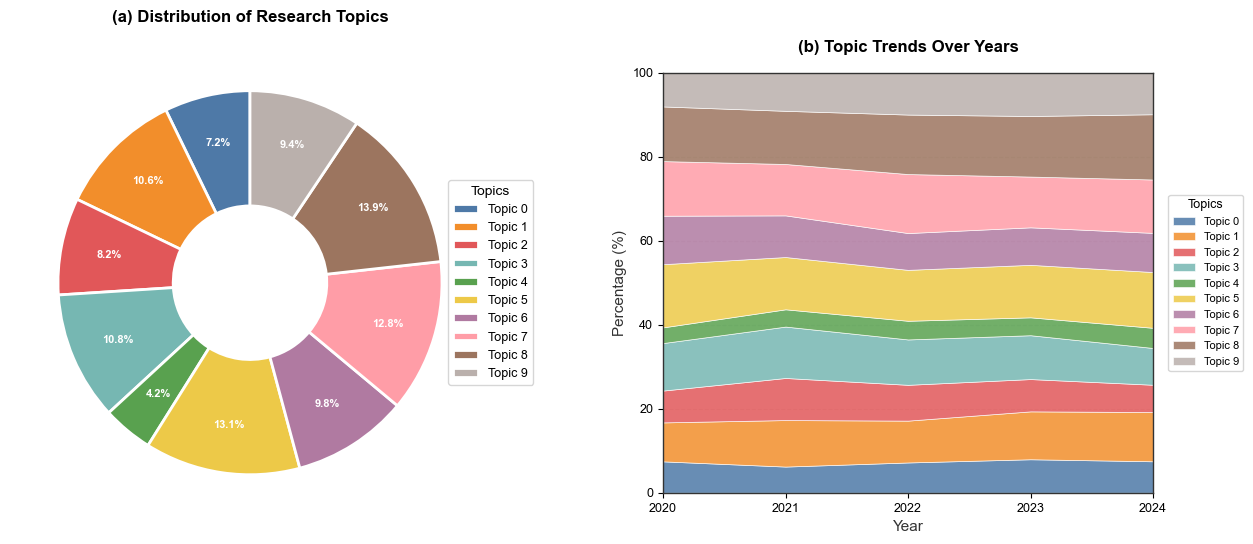

  已保存: Fig1_topic_distribution.png/pdf

绑定图2: 主题词云...


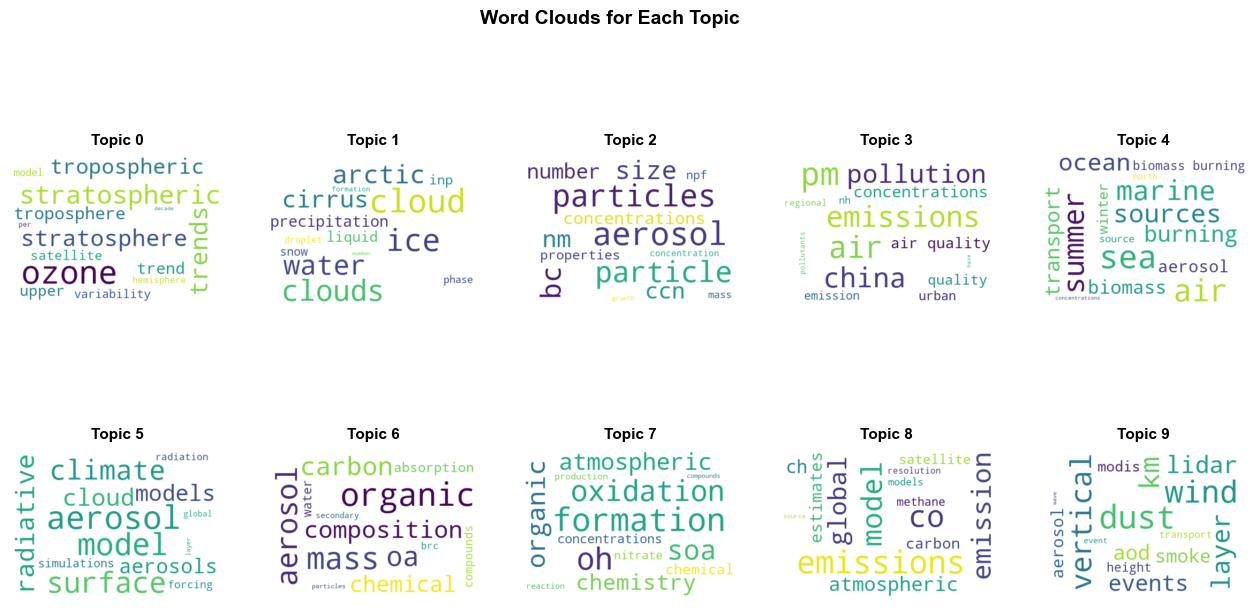

  已保存: Fig2_topic_wordclouds.png/pdf

绑定图3: 主题演化...


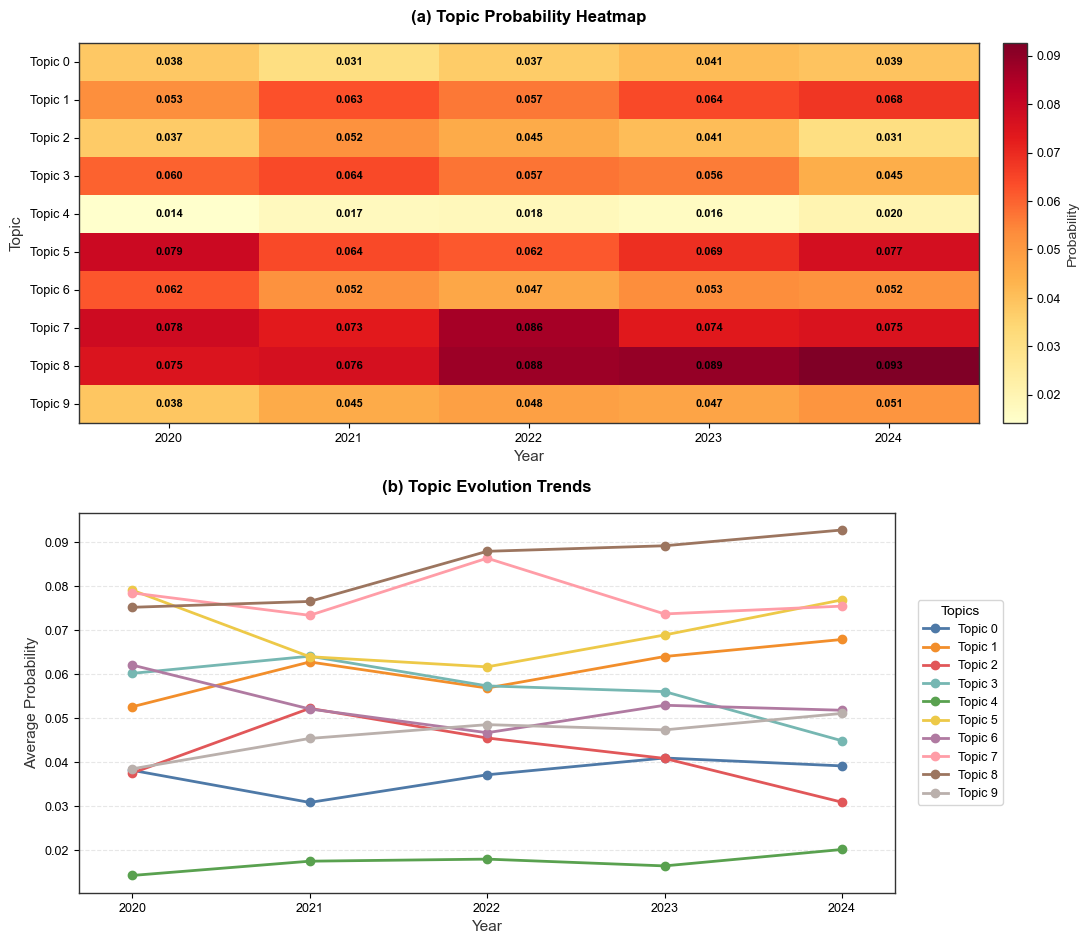

  已保存: Fig3_topic_evolution.png/pdf

绑定图4: 关键词网络...


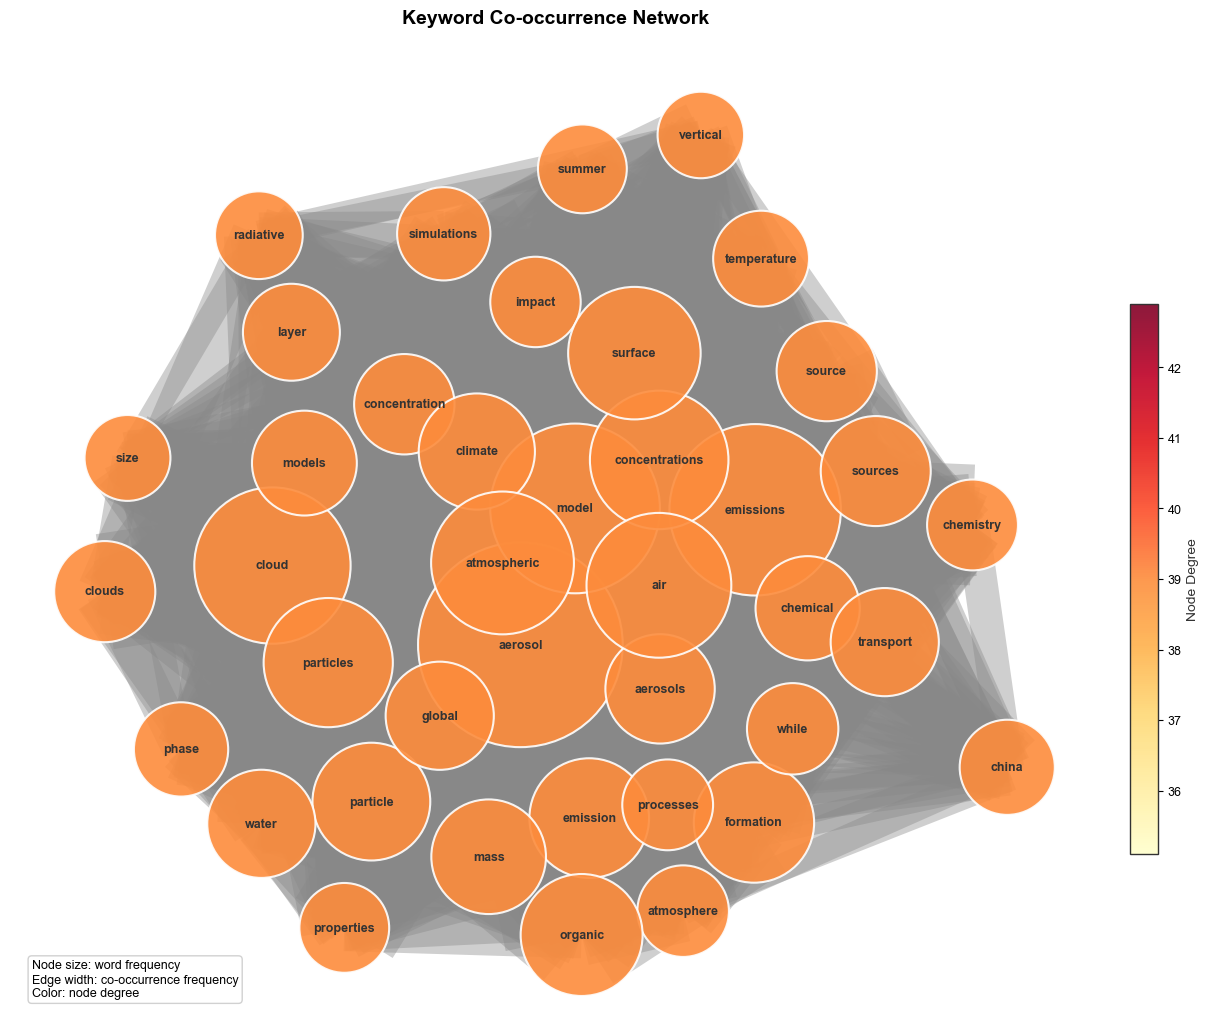

  已保存: Fig4_keyword_network.png/pdf
  网络节点: 40, 边: 780

绑定图5: 研究类型...


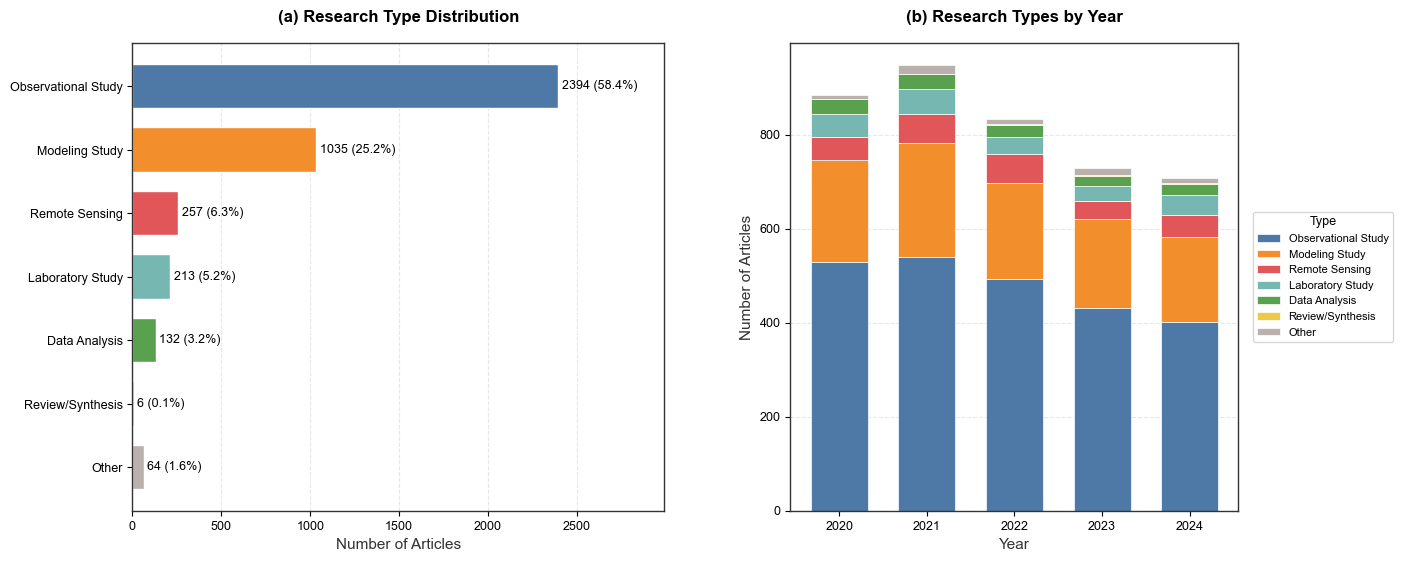

  已保存: Fig5_research_types.png/pdf

绑定图6: 地理分析...


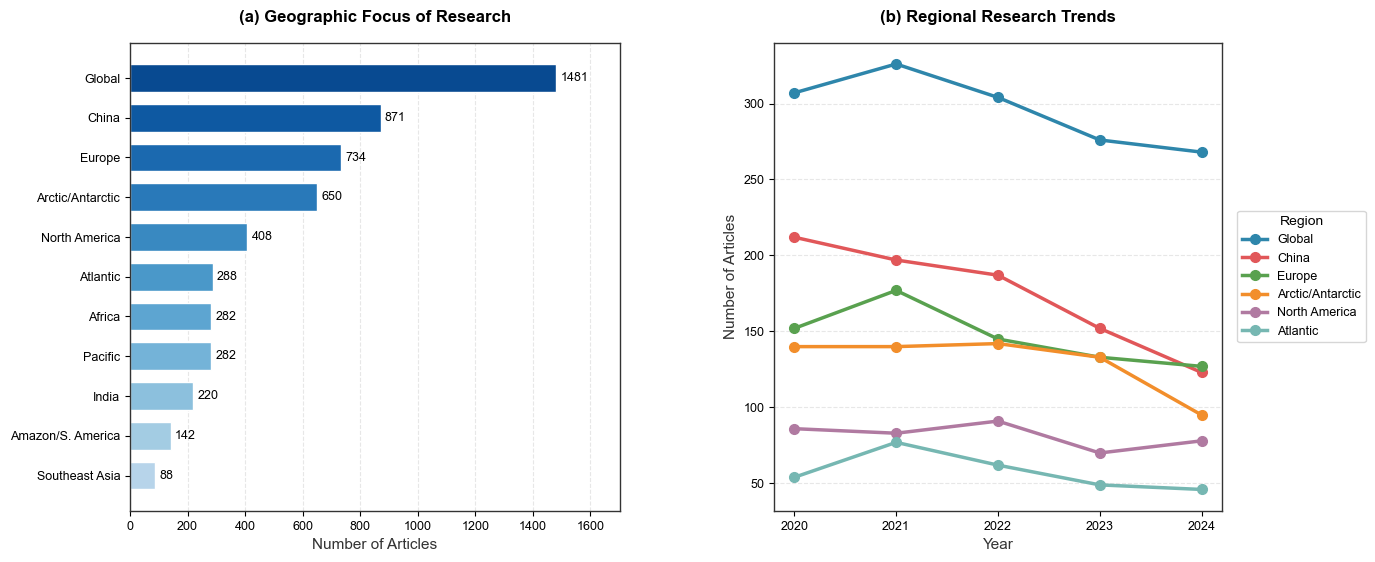

  已保存: Fig6_geographic_analysis.png/pdf

所有图表绑定完成！

输出目录: /Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract/figures

生成的图表:
  - Fig1_topic_distribution.png/pdf
  - Fig2_topic_wordclouds.png/pdf
  - Fig3_topic_evolution.png/pdf
  - Fig4_keyword_network.png/pdf
  - Fig5_research_types.png/pdf
  - Fig6_geographic_analysis.png/pdf



In [8]:
"""
ACP Journal Analysis - Publication-Quality Figures (Fixed)
===========================================================
修复版本 - 解决colorbar与tight_layout冲突问题

作者：Claude Assistant
日期：2024年12月
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter, defaultdict
import re
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from wordcloud import WordCloud

# =============================================================================
# 输出目录配置
# =============================================================================

BASE_OUTPUT_DIR = "/Users/weiyingwan/Desktop/校内课程/学术英语交流（周五）/ACP/abstract"
FIGURE_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
DATA_DIR = os.path.join(BASE_OUTPUT_DIR, "data")
ANALYSIS_DIR = os.path.join(BASE_OUTPUT_DIR, "analysis_results")
TOPIC_DIR = os.path.join(BASE_OUTPUT_DIR, "topics")
NETWORK_DIR = os.path.join(BASE_OUTPUT_DIR, "networks")

os.makedirs(FIGURE_DIR, exist_ok=True)

# =============================================================================
# 配色方案（色盲友好）
# =============================================================================

TOPIC_COLORS = [
    '#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F',
    '#EDC948', '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AC',
]

TYPE_COLORS = {
    'Observational Study': '#4E79A7',
    'Modeling Study': '#F28E2B',
    'Remote Sensing': '#E15759',
    'Laboratory Study': '#76B7B2',
    'Data Analysis': '#59A14F',
    'Review/Synthesis': '#EDC948',
    'Other': '#BAB0AC',
}

# =============================================================================
# 设置绑定风格
# =============================================================================

def setup_style():
    """设置学术期刊绑定风格"""
    plt.rcdefaults()
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'legend.title_fontsize': 10,
        'axes.linewidth': 1.0,
        'axes.edgecolor': '#333333',
        'axes.labelcolor': '#333333',
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'axes.grid': False,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'figure.dpi': 100,
    })
    print("绑定风格已设置")

# =============================================================================
# 数据处理函数
# =============================================================================

def load_data():
    """加载数据"""
    analysis_file = os.path.join(ANALYSIS_DIR, 'articles_with_analysis.csv')
    if os.path.exists(analysis_file):
        df = pd.read_csv(analysis_file)
        print(f"已加载: {len(df)} 条记录")
        return df
    
    csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
    if csv_files:
        filepath = os.path.join(DATA_DIR, sorted(csv_files)[-1])
        df = pd.read_csv(filepath)
        print(f"已加载: {len(df)} 条记录")
        return df
    
    raise FileNotFoundError("未找到数据文件")


def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def get_stopwords():
    base = set(['a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
                'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
                'could', 'should', 'may', 'might', 'must', 'shall', 'can', 'need',
                'it', 'its', 'this', 'that', 'these', 'those', 'we', 'our', 'they',
                'their', 'which', 'who', 'where', 'when', 'what', 'how', 'why',
                'also', 'than', 'more', 'most', 'some', 'any', 'each', 'between',
                'into', 'through', 'during', 'before', 'after', 'above', 'below',
                'both', 'same', 'different', 'such', 'other', 'another', 'many',
                'much', 'few', 'less', 'least', 'only', 'very', 'just', 'even',
                'about', 'over', 'under', 'again', 'further', 'then', 'once',
                'here', 'there', 'all', 'no', 'not', 'nor', 'so', 'too'])
    
    academic = set(['study', 'studies', 'studied', 'research', 'results', 'result',
                   'show', 'shows', 'showed', 'shown', 'find', 'found', 'findings',
                   'using', 'used', 'based', 'however', 'therefore', 'thus', 'hence',
                   'paper', 'article', 'work', 'data', 'analysis', 'method', 'methods',
                   'approach', 'investigated', 'observed', 'observations', 'measured',
                   'measurements', 'calculated', 'estimated', 'determined', 'obtained',
                   'performed', 'conducted', 'presented', 'discussed', 'compared',
                   'evaluated', 'assessed', 'examined', 'analyzed', 'significant',
                   'significantly', 'important', 'particularly', 'generally', 'typically',
                   'usually', 'often', 'well', 'high', 'low', 'large', 'small', 'new',
                   'first', 'second', 'two', 'three', 'several', 'various', 'similar',
                   'potential', 'respectively', 'approximately', 'relatively',
                   'increase', 'increased', 'decrease', 'decreased', 'higher', 'lower',
                   'suggest', 'suggests', 'indicate', 'indicates', 'associated', 'related',
                   'due', 'mainly', 'overall', 'total', 'average', 'mean', 'values',
                   'range', 'level', 'levels', 'effect', 'effects', 'factor', 'factors',
                   'conditions', 'period', 'time', 'day', 'days', 'year', 'years',
                   'region', 'regions', 'area', 'areas', 'site', 'sites', 'order',
                   'magnitude', 'variation', 'variations', 'changes', 'change'])
    
    return base | academic


# =============================================================================
# 图1: 主题分布
# =============================================================================

def plot_topic_distribution(df, lda_output, n_topics=10):
    """绑定主题分布"""
    print("\n绑定图1: 主题分布...")
    
    fig = plt.figure(figsize=(14, 6))
    
    # 左侧: 环形图
    ax1 = fig.add_axes([0.05, 0.1, 0.35, 0.8])
    
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    
    wedges, texts, autotexts = ax1.pie(
        topic_counts.values,
        labels=None,
        autopct='%1.1f%%',
        colors=TOPIC_COLORS[:len(topic_counts)],
        wedgeprops=dict(width=0.6, edgecolor='white', linewidth=2),
        pctdistance=0.75,
        startangle=90
    )
    
    for autotext in autotexts:
        autotext.set_fontsize(8)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    ax1.legend(
        wedges,
        [f'Topic {i}' for i in topic_counts.index],
        title='Topics',
        loc='center left',
        bbox_to_anchor=(0.9, 0.5),
        fontsize=9
    )
    
    ax1.set_title('(a) Distribution of Research Topics', fontsize=12, fontweight='bold', pad=15)
    
    # 右侧: 堆叠面积图
    ax2 = fig.add_axes([0.52, 0.15, 0.35, 0.7])
    
    if 'year' in df.columns:
        topic_year = pd.crosstab(df['year'], df['dominant_topic'])
        topic_year_pct = topic_year.div(topic_year.sum(axis=1), axis=0) * 100
        
        years = topic_year_pct.index.values
        
        ax2.stackplot(
            years,
            [topic_year_pct[i].values for i in range(n_topics)],
            labels=[f'Topic {i}' for i in range(n_topics)],
            colors=TOPIC_COLORS[:n_topics],
            alpha=0.85,
            edgecolor='white',
            linewidth=0.5
        )
        
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Percentage (%)', fontsize=11)
        ax2.set_xlim(years.min(), years.max())
        ax2.set_ylim(0, 100)
        ax2.set_xticks(years)
        
        ax2.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=8,
            title='Topics',
            title_fontsize=9
        )
        
        ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax2.set_axisbelow(True)
    
    ax2.set_title('(b) Topic Trends Over Years', fontsize=12, fontweight='bold', pad=15)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig1_topic_distribution.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig1_topic_distribution.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("  已保存: Fig1_topic_distribution.png/pdf")


# =============================================================================
# 图2: 主题词云
# =============================================================================

def plot_topic_wordclouds(topics, n_topics=10):
    """绑定主题词云"""
    print("\n绑定图2: 主题词云...")
    
    fig, axes = plt.subplots(2, 5, figsize=(16, 7))
    axes = axes.flatten()
    
    for topic_idx in range(n_topics):
        ax = axes[topic_idx]
        
        topic_name = f'Topic_{topic_idx}'
        if topic_name in topics:
            words = topics[topic_name]
            word_freq = {word: (15-i)**1.5 for i, word in enumerate(words[:15])}
            
            wc = WordCloud(
                width=400,
                height=280,
                background_color='white',
                colormap='viridis',
                max_words=15,
                prefer_horizontal=0.8,
                min_font_size=10,
                max_font_size=60,
                relative_scaling=0.5,
                margin=10
            )
            wc.generate_from_frequencies(word_freq)
            
            ax.imshow(wc, interpolation='bilinear')
        
        ax.set_title(f'Topic {topic_idx}', fontsize=11, fontweight='bold', pad=8)
        ax.axis('off')
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#cccccc')
            spine.set_linewidth(1)
    
    plt.suptitle('Word Clouds for Each Topic', fontsize=14, fontweight='bold', y=1.02)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig2_topic_wordclouds.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig2_topic_wordclouds.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("  已保存: Fig2_topic_wordclouds.png/pdf")


# =============================================================================
# 图3: 主题演化（修复版）
# =============================================================================

def plot_topic_evolution(df, lda_output, n_topics=10):
    """绑定主题时间演化 - 修复colorbar冲突"""
    print("\n绑定图3: 主题演化...")
    
    if 'year' not in df.columns:
        print("  无year列，跳过")
        return None
    
    df_temp = df.copy()
    for i in range(n_topics):
        df_temp[f'topic_{i}_prob'] = lda_output[:, i]
    
    yearly_topics = df_temp.groupby('year')[[f'topic_{i}_prob' for i in range(n_topics)]].mean()
    
    # 使用GridSpec代替tight_layout
    fig = plt.figure(figsize=(12, 10))
    
    # 手动设置子图位置
    ax1 = fig.add_axes([0.1, 0.55, 0.75, 0.38])  # [left, bottom, width, height]
    cax1 = fig.add_axes([0.87, 0.55, 0.02, 0.38])  # colorbar位置
    
    ax2 = fig.add_axes([0.1, 0.08, 0.68, 0.38])
    
    # --- 上方: 热力图 ---
    heatmap_data = yearly_topics.T.values
    
    im = ax1.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
    
    ax1.set_xticks(range(len(yearly_topics.index)))
    ax1.set_xticklabels(yearly_topics.index.astype(int))
    ax1.set_yticks(range(n_topics))
    ax1.set_yticklabels([f'Topic {i}' for i in range(n_topics)])
    
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel('Topic', fontsize=11)
    ax1.set_title('(a) Topic Probability Heatmap', fontsize=12, fontweight='bold', pad=15)
    
    for i in range(n_topics):
        for j in range(len(yearly_topics.index)):
            value = heatmap_data[i, j]
            text_color = 'white' if value > 0.12 else 'black'
            ax1.text(j, i, f'{value:.3f}', ha='center', va='center', 
                    fontsize=8, color=text_color, fontweight='bold')
    
    cbar = plt.colorbar(im, cax=cax1)
    cbar.set_label('Probability', fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    
    # --- 下方: 折线图 ---
    for i in range(n_topics):
        ax2.plot(
            yearly_topics.index,
            yearly_topics[f'topic_{i}_prob'],
            marker='o',
            markersize=6,
            linewidth=2,
            label=f'Topic {i}',
            color=TOPIC_COLORS[i]
        )
    
    ax2.set_xlabel('Year', fontsize=11)
    ax2.set_ylabel('Average Probability', fontsize=11)
    ax2.set_title('(b) Topic Evolution Trends', fontsize=12, fontweight='bold', pad=15)
    
    ax2.set_xticks(yearly_topics.index)
    ax2.set_xlim(yearly_topics.index.min() - 0.3, yearly_topics.index.max() + 0.3)
    
    ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax2.set_axisbelow(True)
    
    ax2.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=9,
        title='Topics',
        title_fontsize=10,
        ncol=1
    )
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig3_topic_evolution.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig3_topic_evolution.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("  已保存: Fig3_topic_evolution.png/pdf")
    
    return yearly_topics


# =============================================================================
# 图4: 关键词共现网络（修复版）
# =============================================================================

def plot_keyword_network(df, top_n=50, min_cooccurrence=8):
    """绑定关键词共现网络"""
    print("\n绑定图4: 关键词网络...")
    
    stopwords = get_stopwords()
    
    all_words = []
    doc_words = []
    
    for abstract in df['abstract']:
        if not isinstance(abstract, str):
            doc_words.append([])
            continue
        text = preprocess_text(abstract)
        words = [w for w in text.split() if len(w) > 2 and w not in stopwords]
        doc_words.append(words)
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    top_words = [word for word, count in word_counts.most_common(top_n)]
    top_words_set = set(top_words)
    
    cooccurrence = defaultdict(int)
    for words in doc_words:
        words_in_doc = [w for w in set(words) if w in top_words_set]
        for i, w1 in enumerate(words_in_doc):
            for w2 in words_in_doc[i+1:]:
                pair = tuple(sorted([w1, w2]))
                cooccurrence[pair] += 1
    
    G = nx.Graph()
    for (w1, w2), count in cooccurrence.items():
        if count >= min_cooccurrence:
            G.add_edge(w1, w2, weight=count)
    
    if G.number_of_nodes() == 0:
        print("  网络为空")
        return None, word_counts
    
    degrees = dict(G.degree())
    nodes_to_keep = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:40]
    G_sub = G.subgraph(nodes_to_keep).copy()
    
    # 绘图 - 使用手动布局
    fig = plt.figure(figsize=(14, 11))
    ax = fig.add_axes([0.05, 0.05, 0.78, 0.88])
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.5])
    
    pos = nx.spring_layout(G_sub, k=2.5, iterations=100, seed=42)
    
    node_sizes = [word_counts.get(node, 10) * 3 for node in G_sub.nodes()]
    node_degrees = [G_sub.degree(node) for node in G_sub.nodes()]
    edge_weights = [G_sub[u][v]['weight'] * 0.15 for u, v in G_sub.edges()]
    
    nx.draw_networkx_edges(
        G_sub, pos,
        width=edge_weights,
        alpha=0.4,
        edge_color='#888888',
        ax=ax
    )
    
    nodes = nx.draw_networkx_nodes(
        G_sub, pos,
        node_size=node_sizes,
        node_color=node_degrees,
        cmap=plt.cm.YlOrRd,
        alpha=0.9,
        edgecolors='white',
        linewidths=1.5,
        ax=ax
    )
    
    nx.draw_networkx_labels(
        G_sub, pos,
        font_size=9,
        font_weight='bold',
        font_color='#333333',
        ax=ax
    )
    
    cbar = plt.colorbar(nodes, cax=cax)
    cbar.set_label('Node Degree', fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    
    ax.set_title('Keyword Co-occurrence Network', fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    
    ax.text(0.02, 0.02, 
            'Node size: word frequency\nEdge width: co-occurrence frequency\nColor: node degree',
            transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#cccccc'))
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig4_keyword_network.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig4_keyword_network.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    nx.write_gexf(G, os.path.join(NETWORK_DIR, 'keyword_network.gexf'))
    
    print("  已保存: Fig4_keyword_network.png/pdf")
    print(f"  网络节点: {G_sub.number_of_nodes()}, 边: {G_sub.number_of_edges()}")
    
    return G, word_counts


# =============================================================================
# 图5: 研究类型分布
# =============================================================================

def plot_research_types(df):
    """绑定研究类型分布"""
    print("\n绑定图5: 研究类型...")
    
    research_types = {
        'Observational Study': ['observation', 'observed', 'campaign', 'field', 'in situ',
                                'measurement', 'measured', 'monitoring', 'station'],
        'Modeling Study': ['model', 'modeled', 'modelling', 'simulation', 'simulated',
                          'wrf', 'cmaq', 'geos-chem', 'cam', 'cesm', 'numerical'],
        'Remote Sensing': ['satellite', 'remote sensing', 'lidar', 'radar', 'retrieval',
                          'modis', 'calipso', 'omi', 'tropomi', 'sentinel', 'goes'],
        'Laboratory Study': ['laboratory', 'chamber', 'smog chamber', 'reaction', 
                            'kinetic', 'synthesis', 'experiment'],
        'Data Analysis': ['reanalysis', 'dataset', 'database', 'long-term', 'trend',
                         'statistical', 'machine learning', 'deep learning'],
        'Review/Synthesis': ['review', 'synthesis', 'overview', 'assessment', 'intercomparison']
    }
    
    def classify(abstract):
        if not isinstance(abstract, str):
            return 'Other'
        text = abstract.lower()
        matches = {}
        for rtype, keywords in research_types.items():
            count = sum(1 for kw in keywords if kw in text)
            if count > 0:
                matches[rtype] = count
        return max(matches, key=matches.get) if matches else 'Other'
    
    df['research_type'] = df['abstract'].apply(classify)
    
    type_counts = df['research_type'].value_counts()
    
    type_order = ['Observational Study', 'Modeling Study', 'Remote Sensing', 
                  'Laboratory Study', 'Data Analysis', 'Review/Synthesis', 'Other']
    
    fig = plt.figure(figsize=(14, 6))
    
    # 左侧
    ax1 = fig.add_axes([0.08, 0.12, 0.38, 0.78])
    
    ordered_counts = [type_counts.get(t, 0) for t in type_order if t in type_counts.index or t == 'Other']
    ordered_types = [t for t in type_order if t in type_counts.index or (t == 'Other' and 'Other' in type_counts.index)]
    
    colors = [TYPE_COLORS.get(t, '#BAB0AC') for t in ordered_types]
    
    y_pos = range(len(ordered_types))
    bars = ax1.barh(y_pos, ordered_counts, color=colors, edgecolor='white', linewidth=1, height=0.7)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(ordered_types)
    ax1.invert_yaxis()
    ax1.set_xlabel('Number of Articles', fontsize=11)
    ax1.set_title('(a) Research Type Distribution', fontsize=12, fontweight='bold', pad=15)
    
    for bar, count in zip(bars, ordered_counts):
        ax1.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
                f'{count} ({count/len(df)*100:.1f}%)',
                va='center', fontsize=9)
    
    ax1.set_xlim(0, max(ordered_counts) * 1.25)
    ax1.xaxis.grid(True, linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    # 右侧
    ax2 = fig.add_axes([0.55, 0.12, 0.32, 0.78])
    
    if 'year' in df.columns:
        type_year = pd.crosstab(df['year'], df['research_type'])
        
        cols_ordered = [c for c in type_order if c in type_year.columns]
        type_year = type_year[cols_ordered]
        
        years = type_year.index.values
        x = np.arange(len(years))
        width = 0.65
        
        bottom = np.zeros(len(years))
        for col in cols_ordered:
            color = TYPE_COLORS.get(col, '#BAB0AC')
            ax2.bar(x, type_year[col], width, bottom=bottom, label=col, 
                   color=color, edgecolor='white', linewidth=0.5)
            bottom += type_year[col].values
        
        ax2.set_xticks(x)
        ax2.set_xticklabels(years.astype(int))
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Number of Articles', fontsize=11)
        ax2.set_title('(b) Research Types by Year', fontsize=12, fontweight='bold', pad=15)
        
        ax2.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=8,
            title='Type',
            title_fontsize=9
        )
        
        ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax2.set_axisbelow(True)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig5_research_types.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig5_research_types.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("  已保存: Fig5_research_types.png/pdf")
    
    return df


# =============================================================================
# 图6: 地理区域分析
# =============================================================================

def plot_geographic_analysis(df):
    """绑定地理区域分析"""
    print("\n绑定图6: 地理分析...")
    
    regions = {
        'China': ['china', 'chinese', 'beijing', 'shanghai', 'guangzhou', 
                  'nanjing', 'chengdu', 'pearl river delta', 'yangtze'],
        'Europe': ['europe', 'european', 'germany', 'france', 'uk', 'spain',
                   'italy', 'mediterranean', 'alps', 'scandina'],
        'North America': ['united states', 'usa', 'american', 'canada', 
                          'california', 'texas', 'new york', 'mexico'],
        'Southeast Asia': ['southeast asia', 'indonesia', 'malaysia', 'thailand',
                           'vietnam', 'philippines', 'singapore', 'borneo'],
        'India': ['india', 'indian', 'delhi', 'mumbai', 'ganges', 'himalaya'],
        'Arctic/Antarctic': ['arctic', 'antarctic', 'polar', 'greenland', 'svalbard', 'alaska'],
        'Africa': ['africa', 'african', 'sahara', 'sahel', 'nigeria', 'south africa'],
        'Amazon/S. America': ['amazon', 'brazil', 'south america', 'tropical forest'],
        'Pacific': ['pacific', 'pacific ocean', 'hawaii', 'japan', 'korea'],
        'Atlantic': ['atlantic', 'atlantic ocean', 'caribbean'],
        'Global': ['global', 'worldwide', 'earth', 'planetary']
    }
    
    region_counts = {region: 0 for region in regions}
    region_articles = {region: [] for region in regions}
    
    for idx, row in df.iterrows():
        abstract = str(row.get('abstract', '')).lower()
        title = str(row.get('title', '')).lower()
        text = abstract + ' ' + title
        
        for region, keywords in regions.items():
            if any(kw in text for kw in keywords):
                region_counts[region] += 1
                region_articles[region].append(idx)
    
    fig = plt.figure(figsize=(14, 6))
    
    ax1 = fig.add_axes([0.12, 0.12, 0.35, 0.78])
    
    sorted_regions = sorted(region_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_regions = [(r, c) for r, c in sorted_regions if c > 0]
    
    regions_list = [r for r, c in sorted_regions]
    counts_list = [c for r, c in sorted_regions]
    
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(regions_list)))[::-1]
    
    y_pos = range(len(regions_list))
    bars = ax1.barh(y_pos, counts_list, color=colors, edgecolor='white', linewidth=1, height=0.7)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(regions_list)
    ax1.invert_yaxis()
    ax1.set_xlabel('Number of Articles', fontsize=11)
    ax1.set_title('(a) Geographic Focus of Research', fontsize=12, fontweight='bold', pad=15)
    
    for bar, count in zip(bars, counts_list):
        ax1.text(bar.get_width() + 15, bar.get_y() + bar.get_height()/2,
                f'{count}',
                va='center', fontsize=9)
    
    ax1.set_xlim(0, max(counts_list) * 1.15)
    ax1.xaxis.grid(True, linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    ax2 = fig.add_axes([0.58, 0.12, 0.32, 0.78])
    
    if 'year' in df.columns:
        top_regions = regions_list[:6]
        region_colors = ['#2E86AB', '#E15759', '#59A14F', '#F28E2B', '#B07AA1', '#76B7B2']
        
        for i, region in enumerate(top_regions):
            yearly_counts = []
            for year in sorted(df['year'].unique()):
                count = sum(1 for idx in region_articles[region] 
                           if idx < len(df) and df.loc[idx, 'year'] == year)
                yearly_counts.append(count)
            
            ax2.plot(
                sorted(df['year'].unique()),
                yearly_counts,
                marker='o',
                markersize=7,
                linewidth=2.5,
                label=region,
                color=region_colors[i]
            )
        
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Number of Articles', fontsize=11)
        ax2.set_title('(b) Regional Research Trends', fontsize=12, fontweight='bold', pad=15)
        
        ax2.set_xticks(sorted(df['year'].unique()))
        
        ax2.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=9,
            title='Region',
            title_fontsize=10
        )
        
        ax2.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax2.set_axisbelow(True)
    
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig6_geographic_analysis.png'), dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(os.path.join(FIGURE_DIR, 'Fig6_geographic_analysis.pdf'), bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("  已保存: Fig6_geographic_analysis.png/pdf")
    
    return region_counts


# =============================================================================
# 主程序
# =============================================================================

def run_all_plots():
    """运行所有绑定"""
    print("=" * 70)
    print("ACP期刊分析 - 学术期刊规范图表（修复版）")
    print(f"时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 70)
    
    setup_style()
    
    df = load_data()
    
    # 检查是否需要运行LDA
    if 'dominant_topic' not in df.columns:
        print("\n运行LDA主题建模...")
        
        texts = df['abstract'].apply(preprocess_text).tolist()
        stopwords = list(get_stopwords())
        
        vectorizer = CountVectorizer(
            max_df=0.8, min_df=10,
            stop_words=stopwords,
            max_features=5000,
            ngram_range=(1, 2)
        )
        
        doc_term_matrix = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()
        
        lda = LatentDirichletAllocation(
            n_components=10,
            max_iter=20,
            learning_method='online',
            random_state=42,
            n_jobs=-1
        )
        
        lda_output = lda.fit_transform(doc_term_matrix)
        
        topics = {}
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-16:-1]
            topics[f'Topic_{topic_idx}'] = [feature_names[i] for i in top_words_idx]
        
        df['dominant_topic'] = lda_output.argmax(axis=1)
        df['topic_probability'] = lda_output.max(axis=1)
        
    else:
        # 加载已有的LDA结果
        lda_output = np.zeros((len(df), 10))
        for i in range(10):
            if f'topic_{i}_prob' in df.columns:
                lda_output[:, i] = df[f'topic_{i}_prob']
            else:
                lda_output[df['dominant_topic'] == i, i] = df.loc[df['dominant_topic'] == i, 'topic_probability']
        
        topics_file = os.path.join(TOPIC_DIR, 'lda_topics.csv')
        if os.path.exists(topics_file):
            topics_df = pd.read_csv(topics_file)
            topics = {col: topics_df[col].tolist() for col in topics_df.columns}
        else:
            print("重新计算主题词...")
            texts = df['abstract'].apply(preprocess_text).tolist()
            stopwords = list(get_stopwords())
            
            vectorizer = CountVectorizer(
                max_df=0.8, min_df=10,
                stop_words=stopwords,
                max_features=5000,
                ngram_range=(1, 2)
            )
            
            doc_term_matrix = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()
            
            lda = LatentDirichletAllocation(
                n_components=10,
                max_iter=20,
                learning_method='online',
                random_state=42,
                n_jobs=-1
            )
            
            lda_output = lda.fit_transform(doc_term_matrix)
            
            topics = {}
            for topic_idx, topic in enumerate(lda.components_):
                top_words_idx = topic.argsort()[:-16:-1]
                topics[f'Topic_{topic_idx}'] = [feature_names[i] for i in top_words_idx]
    
    # 绑定所有图表
    plot_topic_distribution(df, lda_output)
    plot_topic_wordclouds(topics)
    plot_topic_evolution(df, lda_output)
    plot_keyword_network(df)
    df = plot_research_types(df)
    plot_geographic_analysis(df)
    
    df.to_csv(os.path.join(ANALYSIS_DIR, 'articles_with_analysis.csv'), index=False)
    
    print("\n" + "=" * 70)
    print("所有图表绑定完成！")
    print("=" * 70)
    print(f"\n输出目录: {FIGURE_DIR}")
    print("""
生成的图表:
  - Fig1_topic_distribution.png/pdf
  - Fig2_topic_wordclouds.png/pdf
  - Fig3_topic_evolution.png/pdf
  - Fig4_keyword_network.png/pdf
  - Fig5_research_types.png/pdf
  - Fig6_geographic_analysis.png/pdf
""")


if __name__ == "__main__":
    run_all_plots()